In [167]:
import pandas as pd
import geopandas as gpd
import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline


import os

data_path = '/home/fterroso/data/'

In [168]:
import warnings
warnings.filterwarnings("ignore")

In [169]:
from datetime import date, timedelta

def generate_target_days_fn(init_date, final_date):

    delta = e_date - i_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = i_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [170]:
import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
target_days = generate_target_days_fn(i_date, e_date)

In [171]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join('data', 'OD', 'date_{}_OD_{}_prov.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [172]:
twt_ods = read_OD_fn('TWT')

In [173]:
ine_ods = read_OD_fn('INE')

## Fix data gaps

### OD with too many values (wrong aggregation)

In [174]:
#date_ = datetime.datetime.strptime('2020-04-07', '%Y-%m-%d')

In [175]:
#twt_od = twt_ods[date_]
#twt_od_fixed = twt_od /2
#twt_ods[date_] = twt_od_fixed

### OD with zero values (extrapolation from previous and next day)

In [176]:
#date_missing_ = datetime.datetime.strptime('2020-04-08', '%Y-%m-%d')
#twt_missing_od = twt_ods[date_missing_]

In [177]:
#twt_missing_od.tail()

In [178]:
#date_ = datetime.datetime.strptime('2020-04-09', '%Y-%m-%d')
#twt_ref_od = twt_ods[date_]

In [179]:
#twt_missing_od = (twt_od_fixed + twt_ref_od)/2

In [180]:
#twt_missing_od.tail()

In [181]:
#twt_ods[date_missing_] = twt_missing_od

## Number of origins and destinations per PROV

In [182]:
def generate_avg_n_origin_destinations_fn(global_od, source, trip_rate_threshold):
    norm_twt_od_global = global_od.div(global_od['total'], axis=0)
    norm_twt_od_global['n_meaningful_dest'] = norm_twt_od_global.apply(lambda row: row[row>trip_rate_threshold].shape[0], axis=1)
    
    trasnsposed_norm_od= norm_twt_od_global.T
    trasnsposed_norm_od['n_meaningful_dest'] = trasnsposed_norm_od.apply(lambda row: row[row>trip_rate_threshold].shape[0], axis=1)
    
    norm_twt_od_global['type'] = 'destination'
    trasnsposed_norm_od['type'] = 'origin'
    
    df = pd.concat([trasnsposed_norm_od['n_meaningful_dest type'.split()],
                norm_twt_od_global['n_meaningful_dest type'.split()]], axis=0)
    
    df['source']= source
    
    return df

In [183]:
def generate_n_origin_dest_global_fn(trip_rate_threshold):
    twt_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD_prov.csv'), index_col=0)
    twt_n_origin_dest_df = generate_avg_n_origin_destinations_fn(twt_od_global, 'TWT', trip_rate_threshold)
    
    ine_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD_prov.csv'), index_col=0)
    ine_n_origin_dest_df = generate_avg_n_origin_destinations_fn(ine_od_global, 'INE', trip_rate_threshold)
    
    _df = pd.concat([twt_n_origin_dest_df, ine_n_origin_dest_df], axis=0)
    
    return _df

In [184]:
n_origin_dest_0_df = generate_n_origin_dest_global_fn(0)

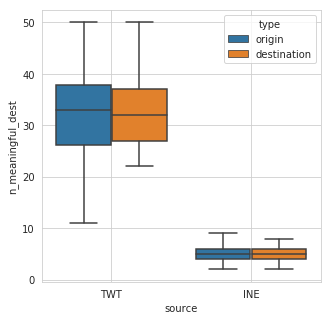

In [185]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=n_origin_dest_0_df, x='source', y='n_meaningful_dest',hue='type', showfliers = False);
ax.grid(True)

In [186]:
n_origin_dest_005_df = generate_n_origin_dest_global_fn(0.05)

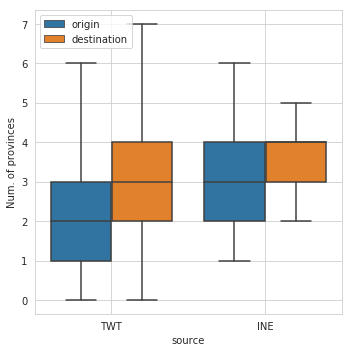

In [187]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=n_origin_dest_005_df, x='source', y='n_meaningful_dest',hue='type', showfliers = False);
ax.set_ylabel("Num. of provinces")
ax.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(os.path.join('figs', 'n_origin_dest_prov.png'))

## Distribution of distances

In [188]:
province_gdf = gpd.read_file(os.path.join('data', 'provinces_with_code.geojson'), driver='GeoJSON')

In [189]:
province_gdf.head()

,NATCODE,NAMEUNIT,CODEUNIT,geometry
0,34104600000,València/Valencia,46,"MULTIPOLYGON (((653037.661 4429500.236, 652229..."
1,34084500000,Toledo,45,"POLYGON ((294238.465 4416957.428, 294235.467 4..."
2,34024400000,Teruel,44,"POLYGON ((765333.011 4512252.351, 764732.031 4..."
3,34094300000,Tarragona,43,"MULTIPOLYGON (((813560.435 4504876.753, 813537..."
4,34074200000,Soria,42,"POLYGON ((583890.589 4603311.305, 583939.589 4..."


In [190]:
'13'.zfill(2)

'13'

In [191]:
province_gdf[province_gdf['CODEUNIT']=='35']

,NATCODE,NAMEUNIT,CODEUNIT,geometry


In [192]:
def calculate_distances_fn(prov_o, prov_d):
    
    prov_o = prov_o.zfill(2)
    prov_d = prov_d.zfill(2)
    
    #print(prov_o, prov_d)
    try:
        po_centroid = province_gdf[province_gdf['CODEUNIT']==str(prov_o)]['geometry'].iloc[0].centroid
        pd_centroid = province_gdf[province_gdf['CODEUNIT']==str(prov_d)]['geometry'].iloc[0].centroid
    except:
        return 0
    return po_centroid.distance(pd_centroid)/1000

In [193]:
def generate_ranking_from_od_fn(global_od, source):
    
    od_no_total= global_od.drop('total')
    od_no_totals= od_no_total.drop(columns='total')
    trips_rank_df = od_no_totals.rank(ascending=False, method='first', axis=1)
    
    distance_ranking_list= [] 
    for o_, row in trips_rank_df.iterrows():
        meaningful_dest = row[row<=10]
        for d_, rank_ in meaningful_dest.items():
            dist = calculate_distances_fn(str(o_), str(d_))#ma_distance_od_df.loc[o_,d_]
            if dist > 0:
                distance_ranking_list.append((o_, d_, rank_, dist, source))
    
    distance_ranking_df = pd.DataFrame.from_records(distance_ranking_list, columns='origin destination ranking distance source'.split())
    return distance_ranking_df

In [194]:
twt_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD_prov.csv'), index_col=0)

In [195]:
twt_trips_rank_df = generate_ranking_from_od_fn(twt_od_global, 'TWT')

In [196]:
ine_od_global= pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD_prov.csv'), index_col=0)

In [197]:
ine_trips_rank_df = generate_ranking_from_od_fn(ine_od_global, 'INE')

In [198]:
trips_rank_df = pd.concat([twt_trips_rank_df, ine_trips_rank_df], axis=0)

In [199]:
trips_rank_df.head()

,origin,destination,ranking,distance,source
0,3,8,6.0,421.955202,TWT
1,3,28,4.0,351.160536,TWT
2,3,46,2.0,100.898049,TWT
3,3,2,7.0,128.697310,TWT
4,3,4,9.0,211.413921,TWT


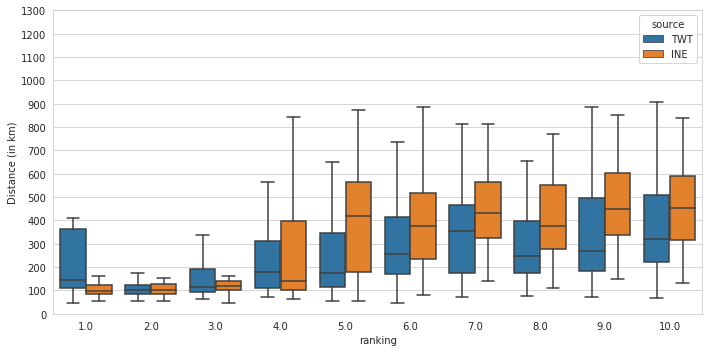

In [200]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
g= sns.boxplot(data=trips_rank_df, x='ranking', y='distance', hue='source', showfliers = False);
g.set_yticks(np.arange(0,1400,100));
g.set_ylabel("Distance (in km)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'distances_origin_dest_prov.png'))

## Comparison methods

In [201]:
from sklearn.metrics import mean_squared_error

In [202]:
def compare_column_ODs_fn(twt_od, ine_od,date_):
    twt_od = twt_od.fillna(0)
    ine_od = ine_od.fillna(0)
    results = []
    ids_ = ine_od.columns.tolist()
    for id_ in ids_:
        row_twt= twt_od[id_]
        row_ine = ine_od[id_]
        
        columns_ine = row_ine[row_ine>0].index.tolist()
        columns_twt = row_twt[row_twt>0].index.tolist()
 
        if 'total' in columns_ine:
            columns_ine.remove('total')
         
        if 'total' in columns_twt:
            columns_twt.remove('total')

        target_columns = set(columns_ine).union(set(columns_twt))
        if len(target_columns)>0:
            #target_columns.remove('total')
            frow_twt = row_twt[target_columns]
            frow_ine = row_ine[target_columns]

            norm_rown_ine= frow_ine
            sum_ine= sum(frow_ine)
            if sum_ine >0:
                norm_rown_ine= frow_ine/sum_ine

            norm_rown_twt= frow_twt
            sum_twt= sum(frow_twt)
            if sum_twt>0:
                norm_rown_twt= frow_twt/sum_twt

            corr_= frow_ine.corr(frow_twt)           
            rmse_= mean_squared_error(norm_rown_ine, norm_rown_twt)        
                 
            intersect_columns = set(columns_ine).intersection(set(columns_twt))
            overlap = len(intersect_columns)/len(target_columns)

            print(set(columns_ine), set(columns_twt), set(columns_ine).intersection(set(columns_twt)),overlap)

            
            results.append((id_, corr_, rmse_, overlap, date_))
    
    return results

In [203]:
def compare_row_ODs_fn(twt_od, ine_od,date_):
    twt_od = twt_od.fillna(0)
    ine_od = ine_od.fillna(0)
    results = []
    ids_ = ine_od.index.tolist()
    for id_ in ids_:
        row_twt= twt_od.loc[id_]
        row_ine = ine_od.loc[id_]
        
        columns_ine = row_ine[row_ine>0].index.tolist()
        columns_twt = row_twt[row_twt>0].index.tolist()
        
        if 'total' in columns_ine:
            columns_ine.remove('total')
         
        if 'total' in columns_twt:
            columns_twt.remove('total')
            
        target_columns = set(columns_ine).union(set(columns_twt))
        if len(target_columns)>0:
            #target_columns.remove('total')
            frow_twt = row_twt[target_columns]
            frow_ine = row_ine[target_columns]

            norm_rown_ine= frow_ine
            sum_ine= sum(frow_ine)
            if sum_ine >0:
                norm_rown_ine= frow_ine/sum_ine

            norm_rown_twt= frow_twt
            sum_twt= sum(frow_twt)
            if sum_twt>0:
                norm_rown_twt= frow_twt/sum_twt

            corr_= frow_ine.corr(frow_twt)           
            rmse_= mean_squared_error(norm_rown_ine, norm_rown_twt)
            
            intersect_columns = set(columns_ine).intersection(set(columns_twt))
            overlap = len(intersect_columns)/len(target_columns)

            #print(set(columns_ine), set(columns_twt), intersect_columns, target_columns, overlap)

            
            results.append((id_, corr_, rmse_, overlap, date_))
    
    return results

In [204]:
def generate_comparive_fn(axis=0):
    all_results = []
    comparison_method = compare_row_ODs_fn
    if axis==1:
        comparison_method= compare_column_ODs_fn
        
    for d in tqdm_notebook(target_days):
        date_results = comparison_method(twt_ods[d], ine_ods[d],d)
        all_results= all_results + date_results
    results_df = pd.DataFrame.from_records(all_results, columns='MA_id corr rmse overlap date'.split())
    results_df= results_df.dropna(axis=0)
    results_df['date'] = results_df['date'].astype(str)
    
    return results_df

## Compare outgoing flows

In [205]:
date_results_df=generate_comparive_fn(axis=0)

In [206]:
date_results_df.head()

,MA_id,corr,rmse,overlap,date
0,3,0.657886,0.040595,0.375000,2020-04-01
1,8,0.915642,0.015218,0.272727,2020-04-01
2,28,0.296189,0.042408,0.157895,2020-04-01
3,41,0.645822,0.037565,0.500000,2020-04-01
4,46,0.099569,0.090627,0.333333,2020-04-01


In [207]:
import seaborn as sns

### Pearson correlation

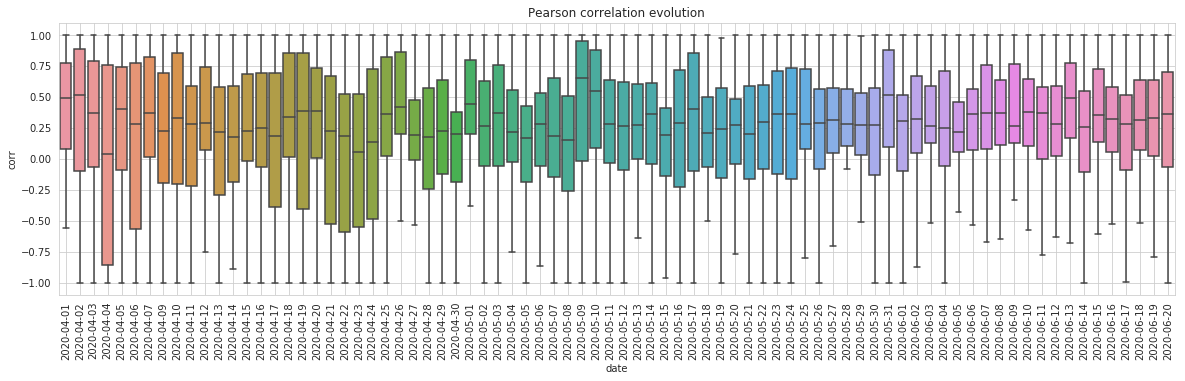

In [208]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax= sns.boxplot(data=date_results_df, x='date', y='corr',showfliers = False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(True)
plt.title("Pearson correlation evolution");

### RMSE

In [209]:
median_date_results_df= date_results_df.groupby('date')['rmse'].median().to_frame()

In [210]:
median_date_results_df.reset_index().head()

,date,rmse
0,2020-04-01,0.055117
1,2020-04-02,0.080156
2,2020-04-03,0.071950
3,2020-04-04,0.127210
4,2020-04-05,0.079637


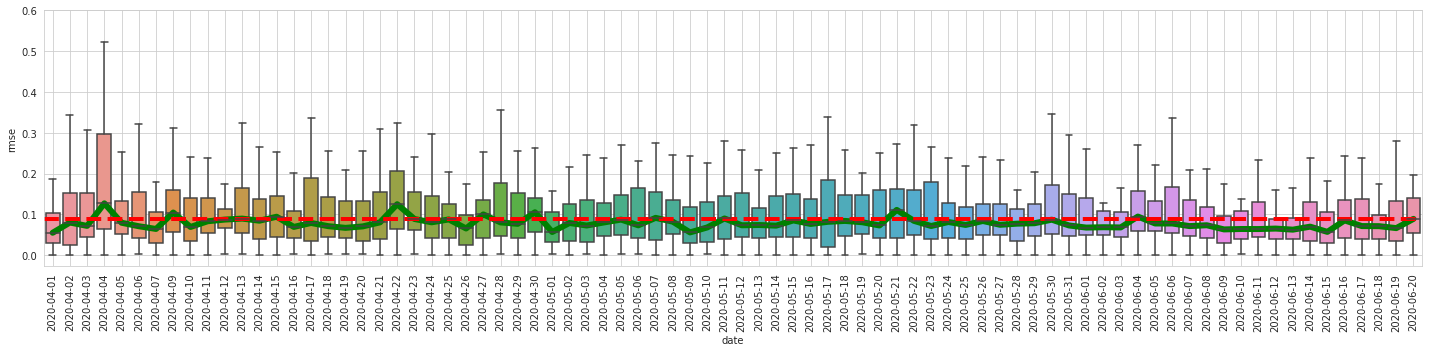

In [211]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='rmse',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='rmse',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,0.7,0.1))

ax.axhline(0.09, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("RMSE evolution (outgoing flow)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'rmse_outgoing_prov.png'))

### Destinations overlap

In [212]:
median_date_results_df= date_results_df.groupby('date')['overlap'].median().to_frame()

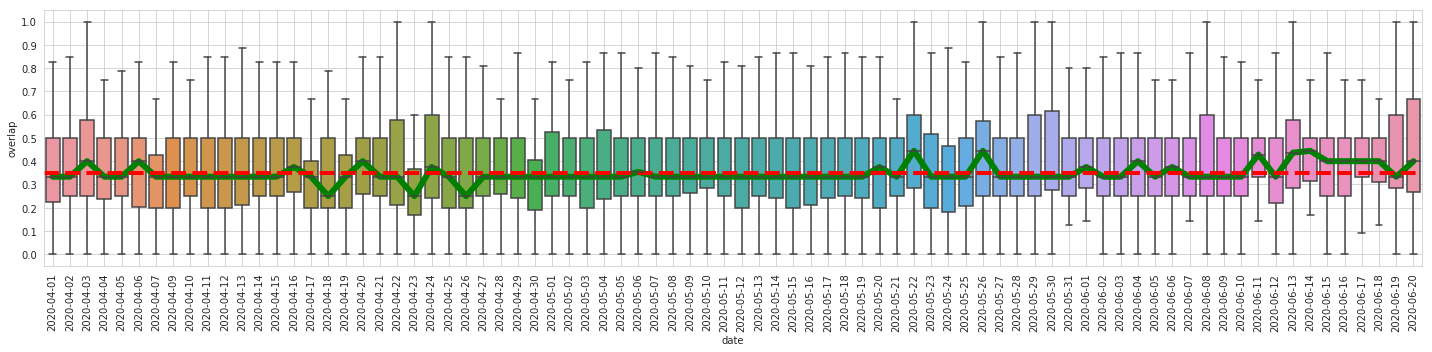

In [326]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='overlap',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='overlap',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,1.1,0.1))

ax.axhline(0.35, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("Destination overlap evolution");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'dest_overlap_prov.png'))

## Compare incoming flows

In [214]:
date_results_df=generate_comparive_fn(axis=1)

{'3', '46', '2', '30'} {'46', '10', '16', '18', '2', '28', '3', '30'} {'3', '46', '2', '30'} 0.5
{'8', '43', '17'} {'8', '46', '16', '4', '25', '7', '17', '28', '3', '29', '43'} {'8', '43', '17'} 0.2727272727272727
{'45', '28', '19'} {'8', '49', '46', '10', '16', '45', '4', '19', '47', '2', '37', '41', '28', '3', '9', '30'} {'45', '28', '19'} 0.1875
{'14', '11', '41'} {'14', '45', '41', '21', '29', '11'} {'14', '11', '41'} 0.5
{'3', '46', '2', '12'} {'8', '46', '16', '34', '28', '3', '43', '12'} {'3', '46', '12'} 0.3333333333333333
{'46', '16', '2', '13', '3'} {'2'} {'2'} 0.2
{'30', '4'} {'14', '46', '4', '44', '28', '29'} {'4'} 0.14285714285714285
{'39', '33', '27'} {'36'} set() 0.0
{'5'} {'5', '37'} {'5'} 0.5
{'10', '6', '21'} {'6', '41'} {'6'} 0.25
{'39'} set() set() 0.0
{'9', '1'} {'1', '10', '9', '28'} {'9', '1'} 0.5
{'10', '6'} {'10', '2'} {'10'} 0.3333333333333333
{'51'} set() set() 0.0
{'15', '36', '27'} {'15'} {'15'} 0.3333333333333333
{'14', '13', '41'} {'14', '23', '18', '4'

{'25', '22'} set() set() 0.0
{'6', '11', '41', '21'} {'21'} {'21'} 0.25
{'14', '23'} set() set() 0.0
{'24'} {'8', '24'} {'24'} 0.5
{'25', '22'} {'25', '22'} {'25', '22'} 1.0
{'31', '1', '26'} set() set() 0.0
{'15', '33', '27'} set() set() 0.0
{'29', '11'} {'29', '45', '22'} {'29'} 0.25
{'52'} set() set() 0.0
{'3', '30', '4'} {'30'} {'30'} 0.3333333333333333
{'31', '50', '26'} {'31', '43', '20'} {'31'} 0.2
{'32', '36'} {'32', '36'} {'32', '36'} 1.0
{'34'} set() set() 0.0
{'15', '36', '32'} {'32', '36', '27'} {'32', '36'} 0.5
{'37'} {'28', '37'} {'37'} 0.5
{'40'} set() set() 0.0
{'42'} {'40'} set() 0.0
{'8', '43', '12'} {'8', '12', '43', '4'} {'8', '43', '12'} 0.75
{'44'} {'50'} set() 0.0
{'38'} set() set() 0.0
{'45', '28'} {'29', '45', '28'} {'45', '28'} 0.6666666666666666
{'47'} {'47', '1'} {'47'} 0.5
{'9', '48', '1'} {'2'} set() 0.0
{'49'} set() set() 0.0
{'39', '48', '1'} set() set() 0.0
{'31', '50'} {'50', '44'} {'50'} 0.3333333333333333
{'7'} {'7', '41', '28'} {'7'} 0.3333333333333

{'8', '43', '12'} {'8', '43', '23', '4'} {'8', '43'} 0.4
{'44'} {'50'} set() 0.0
{'38'} set() set() 0.0
{'45', '28'} {'23', '16', '45', '13', '28'} {'45', '28'} 0.4
{'47'} {'47', '5', '28', '50', '37'} {'47'} 0.2
{'9', '48', '1', '26'} {'50', '9', '1', '26'} {'9', '1', '26'} 0.6
{'49'} {'24', '49'} {'49'} 0.5
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50'} {'8', '25', '20', '28', '44', '31', '50', '30'} {'31', '50'} 0.25
{'7'} {'8', '7'} {'7'} 0.5
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '4', '13', '42', '21', '3', '12', '10', '2', '7', '5', '20', '27', '31', '29', '

{'49'} {'34', '49'} {'49'} 0.5
{'39', '48', '20', '1'} {'1'} {'1'} 0.25
{'31', '50'} {'50', '28', '12'} {'50'} 0.25
{'7'} {'31', '7', '28'} {'7'} 0.3333333333333333
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '13', '42', '21', '3', '12', '51', '10', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '13', '42', '21', '3', '29', '12', '51', '10', '2', '7', '5', '20', '27', '

{'28', '19'} {'28', '19'} {'28', '19'} 1.0
{'25', '22'} {'22'} {'22'} 0.5
{'6', '11', '41', '21'} {'32', '41', '21'} {'41', '21'} 0.4
{'14', '23'} {'18', '23'} {'23'} 0.3333333333333333
{'24'} {'24', '46', '49'} {'24'} 0.3333333333333333
{'25', '22'} {'8', '25', '43'} {'25'} 0.25
{'31', '26'} {'20', '28', '26'} {'26'} 0.25
{'15', '33', '27'} {'36', '32', '15', '28', '27'} {'15', '27'} 0.3333333333333333
{'29', '11'} {'14', '18', '4', '41', '28', '29'} {'29'} 0.14285714285714285
{'52'} set() set() 0.0
{'3', '2', '30', '4'} {'14', '23', '18', '4', '28', '3', '30'} {'3', '4', '30'} 0.375
{'31', '50', '26'} {'31', '47', '36', '28'} {'31'} 0.16666666666666666
{'32', '36'} {'32', '9'} {'32'} 0.3333333333333333
{'34'} {'34', '37'} {'34'} 0.5
{'15', '36', '32'} {'15', '9', '36', '27'} {'15', '36'} 0.4
{'37'} {'49', '28', '37'} {'37'} 0.3333333333333333
{'40'} {'40'} {'40'} 1.0
{'42'} {'42', '41'} {'42'} 0.5
{'8', '43', '12'} {'8', '43', '17'} {'8', '43'} 0.5
{'44'} {'25', '50', '45', '44'} {'4

{'42'} {'47', '42'} {'42'} 0.5
{'8', '43', '12'} {'8', '45', '17', '28', '43', '12'} {'8', '43', '12'} 0.5
{'44'} set() set() 0.0
{'38'} set() set() 0.0
{'45', '5', '28', '13'} {'36', '45', '2', '13', '28', '43', '30'} {'45', '28', '13'} 0.375
{'47', '40'} {'47', '37'} {'47'} 0.3333333333333333
{'9', '48', '1', '26'} {'9', '1', '30'} {'9', '1'} 0.4
{'49'} {'28'} set() 0.0
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50'} {'8', '22', '19', '44', '31', '50'} {'31', '50'} 0.3333333333333333
{'7'} {'8', '7'} {'7'} 0.5
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '22', '4', '13', '42

{'30', '4'} {'16', '18', '4'} {'4'} 0.25
{'33', '27'} set() set() 0.0
{'5'} {'5', '28'} {'5'} 0.5
{'10', '6', '21'} {'6', '11', '44'} {'6'} 0.2
{'39'} set() set() 0.0
{'9', '1'} {'34', '23', '1', '27'} {'1'} 0.2
{'10', '6'} {'10', '6', '28'} {'10', '6'} 0.6666666666666666
{'51'} {'29', '11'} set() 0.0
{'15', '36', '27'} {'15', '45', '28'} {'15'} 0.2
{'14', '23', '41'} {'14', '16', '18', '41', '11'} {'14', '41'} 0.3333333333333333
{'2', '14', '13'} {'13', '41', '45', '42'} {'13'} 0.16666666666666666
{'46', '43', '12'} {'46', '7', '50', '12'} {'46', '12'} 0.4
{'16'} {'8', '16', '44', '28', '11', '30'} {'16'} 0.16666666666666666
{'29', '11', '41', '21'} {'46', '15', '41', '28', '29', '11'} {'29', '11', '41'} 0.42857142857142855
{'35'} set() set() 0.0
{'8', '17'} {'8', '43', '50', '17'} {'8', '17'} 0.5
{'48', '20'} {'24'} set() 0.0
{'18', '23'} {'43', '18'} {'18'} 0.3333333333333333
{'28', '19'} {'16', '31', '28', '19'} {'28', '19'} 0.5
{'22'} {'50', '22', '28'} {'22'} 0.3333333333333333
{

{'9', '1'} {'28', '19'} set() 0.0
{'10', '6', '5'} {'10', '37'} {'10'} 0.25
{'51'} {'51'} {'51'} 1.0
{'15', '36', '27'} {'15', '36'} {'15', '36'} 0.6666666666666666
{'14', '13', '41', '23'} {'29', '14', '41', '18'} {'14', '41'} 0.3333333333333333
{'2', '14', '13', '45'} {'7', '13', '28'} {'13'} 0.16666666666666666
{'46', '43', '12'} {'43', '36', '12'} {'43', '12'} 0.5
{'16', '2'} {'8', '46', '16', '41', '28', '11'} {'16'} 0.14285714285714285
{'29', '11', '41', '21'} {'11', '41'} {'11', '41'} 0.5
{'35'} set() set() 0.0
{'8', '17'} {'8', '41', '17'} {'8', '17'} 0.6666666666666666
{'48', '20'} set() set() 0.0
{'18'} {'18', '23', '28', '30'} {'18'} 0.25
{'28', '19'} {'28', '19'} {'28', '19'} 1.0
{'25', '22'} {'22'} {'22'} 0.5
{'6', '11', '41', '21'} {'41', '21', '4'} {'41', '21'} 0.4
{'14', '23'} {'23'} {'23'} 0.5
{'24'} {'24', '49'} {'24'} 0.5
{'25', '22', '17'} {'8', '25'} {'25'} 0.25
{'31', '26'} {'16', '26'} {'26'} 0.3333333333333333
{'15', '33', '27'} {'27'} {'27'} 0.3333333333333333


{'15', '36', '32'} {'15', '43', '36'} {'15', '36'} 0.5
{'37'} {'10', '49', '28', '37'} {'37'} 0.25
{'47', '40'} {'47', '28'} {'47'} 0.3333333333333333
{'42'} {'42', '30'} {'42'} 0.5
{'8', '43', '12'} {'8', '7', '17', '43', '12'} {'8', '43', '12'} 0.6
{'44'} {'46'} set() 0.0
{'38'} set() set() 0.0
{'13', '28', '45'} {'45', '6', '13', '28', '29'} {'13', '28', '45'} 0.6
{'47'} {'47', '22', '37'} {'47'} 0.3333333333333333
{'9', '48', '1', '26'} {'9', '20', '17', '1'} {'9', '1'} 0.3333333333333333
{'49'} {'24', '47', '49', '37'} {'49'} 0.25
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50'} {'8', '44', '28', '31', '50'} {'31', '50'} 0.4
{'7'} {'8', '7'} {'7'} 0.5
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1'

{'46', '16', '2', '13', '3', '30'} {'3', '16', '2', '13'} {'3', '16', '2', '13'} 0.6666666666666666
{'30', '4'} {'18', '4'} {'4'} 0.3333333333333333
{'39', '33', '27'} set() set() 0.0
{'5', '37'} set() set() 0.0
{'10', '6', '21'} {'10', '29', '6'} {'10', '6'} 0.5
{'39', '33'} set() set() 0.0
{'9', '1'} {'24', '1', '47', '34', '9'} {'9', '1'} 0.4
{'10', '6'} {'10', '6', '26'} {'10', '6'} 0.6666666666666666
{'51'} set() set() 0.0
{'15', '36', '27'} {'15', '46', '36'} {'15', '36'} 0.5
{'14', '13', '41', '23'} {'14', '23', '16', '41', '17', '21', '29', '11'} {'14', '23', '41'} 0.3333333333333333
{'14', '45', '2', '6', '13'} {'16', '50', '13', '28'} {'13'} 0.125
{'46', '43', '12'} {'2', '22', '43', '12'} {'43', '12'} 0.4
{'16', '2'} {'8', '46', '10', '19', '2', '5', '13', '28', '21', '50'} {'2'} 0.09090909090909091
{'29', '11', '41', '21'} {'45', '4', '41', '29', '11'} {'29', '11', '41'} 0.5
{'35'} set() set() 0.0
{'8', '17'} {'8', '36', '4', '17', '3'} {'8', '17'} 0.4
{'48', '20'} set() se

{'35'} set() set() 0.0
{'8', '25', '17'} {'8', '43', '17', '28'} {'8', '17'} 0.4
{'48', '20'} {'31'} set() 0.0
{'18', '23'} {'36', '18', '19', '4', '11'} {'18'} 0.16666666666666666
{'28', '19'} {'46', '28', '19'} {'28', '19'} 0.6666666666666666
{'25', '22'} {'8', '25', '50', '22'} {'25', '22'} 0.5
{'6', '11', '41', '21'} {'11', '41', '21'} {'11', '41', '21'} 0.75
{'14', '23', '18'} {'18', '14', '23', '28'} {'14', '23', '18'} 0.75
{'24'} {'24', '34', '49'} {'24'} 0.3333333333333333
{'25', '22'} {'8', '25'} {'25'} 0.3333333333333333
{'31', '1', '26'} {'26'} {'26'} 0.3333333333333333
{'15', '33', '27'} {'36', '27'} {'27'} 0.25
{'29', '14', '11', '41'} {'8', '51', '14', '18', '28', '29'} {'29', '14'} 0.25
{'52'} set() set() 0.0
{'3', '2', '30', '4'} {'50', '30', '28', '4'} {'4', '30'} 0.3333333333333333
{'31', '50', '26'} {'31', '19'} {'31'} 0.25
{'32', '36'} {'8', '32'} {'32'} 0.3333333333333333
{'34'} {'24', '16', '42'} set() 0.0
{'15', '36', '32'} {'36', '15', '34', '28', '27', '9'} {'1

{'25', '22'} {'25', '22'} {'25', '22'} 1.0
{'6', '11', '41', '21'} {'11', '41', '21'} {'11', '41', '21'} 0.75
{'14', '23', '18'} {'14', '23', '28'} {'14', '23'} 0.5
{'24'} {'24'} {'24'} 1.0
{'25', '22'} {'43', '25', '22', '28'} {'25', '22'} 0.5
{'31', '1', '26'} {'31', '1', '26'} {'31', '1', '26'} 1.0
{'15', '33', '27'} {'32', '36', '27'} {'27'} 0.2
{'29', '11'} {'29', '14', '11', '4'} {'29', '11'} 0.5
{'52'} set() set() 0.0
{'3', '2', '30', '4'} {'3', '16', '28', '30'} {'3', '30'} 0.3333333333333333
{'31', '50', '26'} {'8', '31'} {'31'} 0.25
{'32', '36'} {'32', '36'} {'32', '36'} 1.0
{'34'} {'8', '46', '50', '28'} set() 0.0
{'15', '36', '32'} {'15', '36', '28', '27'} {'15', '36'} 0.4
{'37'} {'37', '6', '28', '12'} {'37'} 0.25
{'40'} {'40', '28'} {'40'} 0.5
{'42'} {'42', '28'} {'42'} 0.5
{'8', '43', '12'} {'8', '43', '50', '41'} {'8', '43'} 0.4
{'44'} {'22', '28'} set() 0.0
{'38'} set() set() 0.0
{'5', '28', '45'} {'10', '45', '5', '13', '28', '50'} {'5', '28', '45'} 0.5
{'47'} {'47', 

{'47', '40'} {'49', '47', '30', '41', '50', '37'} {'47'} 0.14285714285714285
{'9', '48', '1', '26'} {'1', '26'} {'1', '26'} 0.5
{'49'} {'32'} set() 0.0
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50', '22'} {'8', '26', '46', '22', '28', '50'} {'50', '22'} 0.2857142857142857
{'7'} {'8', '46', '25', '7', '41'} {'7'} 0.2
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '22', '4', '13', '42', '21', '3', '12', '51', '10', '2', '7', '5', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', '6',

{'37'} {'47', '49', '28', '37'} {'37'} 0.25
{'47', '40'} {'40', '28'} {'40'} 0.3333333333333333
{'42'} set() set() 0.0
{'8', '43', '12'} {'8', '7', '17', '43', '12'} {'8', '43', '12'} 0.6
{'43', '44'} set() set() 0.0
{'38'} set() set() 0.0
{'45', '5', '28', '13'} {'10', '16', '45', '5', '13', '28'} {'5', '45', '28', '13'} 0.6666666666666666
{'47', '40'} {'47', '34', '41', '28'} {'47'} 0.2
{'9', '48', '1', '26'} {'9', '23', '1', '12'} {'9', '1'} 0.3333333333333333
{'24', '49'} {'46', '47'} set() 0.0
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50', '22'} {'50', '44', '28'} {'50'} 0.2
{'7'} {'46', '7', '50', '28'} {'7'} 0.25
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43'

{'3', '46', '2', '12'} {'3', '46', '43', '16'} {'3', '46'} 0.3333333333333333
{'46', '2', '13', '3', '30'} {'3', '16', '2', '28'} {'3', '2'} 0.2857142857142857
{'30', '4'} {'23', '28', '4'} {'4'} 0.25
{'39', '33', '27'} set() set() 0.0
{'5', '37'} {'15', '46', '9', '37'} {'37'} 0.2
{'10', '6'} {'8', '10', '6', '41', '28'} {'10', '6'} 0.4
{'39', '33'} set() set() 0.0
{'9', '1'} {'9', '41', '37'} {'9'} 0.25
{'10', '6', '5'} {'10', '45'} {'10'} 0.25
{'51'} set() set() 0.0
{'15', '36', '27'} {'15', '31', '36'} {'15', '36'} 0.5
{'14', '13', '41', '23'} {'14', '16', '18', '4', '41', '28', '29'} {'14', '41'} 0.2222222222222222
{'2', '14', '13'} {'3', '13', '28'} {'13'} 0.2
{'46', '43', '12'} {'46', '12', '41', '43', '50', '30'} {'46', '43', '12'} 0.5
{'16', '2', '45'} {'8', '14', '46', '16', '2', '25', '5', '44', '28'} {'16', '2'} 0.2
{'29', '11', '41', '21'} {'46', '41', '28', '29', '11'} {'29', '11', '41'} 0.5
{'35'} set() set() 0.0
{'8', '17'} {'8', '7', '43', '17'} {'8', '17'} 0.5
{'48', 

{'16', '2', '45'} {'46', '16', '45', '2', '41', '28', '30'} {'16', '2', '45'} 0.42857142857142855
{'29', '11', '41', '21'} {'51', '14', '40', '29', '11'} {'29', '11'} 0.2857142857142857
{'35'} set() set() 0.0
{'8', '25', '17'} {'8', '7', '6', '17', '30'} {'8', '17'} 0.3333333333333333
{'48', '20'} set() set() 0.0
{'18'} {'29', '18', '41', '4'} {'18'} 0.25
{'28', '19'} {'28', '19'} {'28', '19'} 1.0
{'25', '50', '22'} {'25', '22', '28'} {'25', '22'} 0.5
{'6', '11', '41', '21'} {'45', '41', '21'} {'41', '21'} 0.4
{'14', '23'} {'16', '13', '41', '23'} {'23'} 0.2
{'24', '32', '33'} {'24', '34', '28'} {'24'} 0.2
{'25', '22', '17'} {'8', '25', '3', '43', '50', '30'} {'25'} 0.125
{'31', '1', '26'} {'46', '26'} {'26'} 0.25
{'15', '33', '27'} {'36'} set() 0.0
{'29', '11'} {'14', '23', '18', '4', '7', '41', '28', '29', '11'} {'29', '11'} 0.2222222222222222
{'52'} set() set() 0.0
{'3', '30', '4'} {'46', '16', '28', '3', '30'} {'3', '30'} 0.3333333333333333
{'31', '50', '26'} {'31', '50', '41'} {'3

{'15', '33', '27'} {'32', '36', '21', '27'} {'27'} 0.16666666666666666
{'29', '11'} {'8', '23', '16', '18', '7', '41', '28', '29', '11'} {'29', '11'} 0.2222222222222222
{'52'} set() set() 0.0
{'3', '30', '4'} {'8', '16', '2', '7', '28', '30'} {'30'} 0.125
{'31', '50', '26'} {'31'} {'31'} 0.3333333333333333
{'32', '36'} {'32', '6'} {'32'} 0.3333333333333333
{'34'} set() set() 0.0
{'15', '36', '32'} {'24', '36', '32', '15', '28'} {'15', '36', '32'} 0.6
{'37'} {'49', '37'} {'37'} 0.5
{'40'} set() set() 0.0
{'42'} {'26'} set() 0.0
{'8', '43', '44', '12'} {'8', '25', '17', '28', '43', '12'} {'8', '43', '12'} 0.42857142857142855
{'44'} set() set() 0.0
{'38'} set() set() 0.0
{'5', '28', '45'} {'10', '45'} {'45'} 0.25
{'47'} {'47', '5'} {'47'} 0.5
{'9', '48', '1', '26'} {'8', '1', '9', '28'} {'9', '1'} 0.3333333333333333
{'49'} {'41'} set() 0.0
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50'} {'50', '22'} {'50'} 0.3333333333333333
{'7'} {'8', '7', '42', '30'} {'7'} 0.25
{'8', '23', '49', '

{'24', '32'} {'24', '49', '28', '37'} {'24'} 0.2
{'25', '22', '17'} {'3', '8', '25', '30'} {'25'} 0.16666666666666666
{'31', '1', '26'} {'50', '1', '26'} {'1', '26'} 0.5
{'15', '33', '27'} {'27'} {'27'} 0.3333333333333333
{'14', '18', '41', '29', '11'} {'29', '18', '19'} {'29', '18'} 0.3333333333333333
{'52'} set() set() 0.0
{'3', '2', '30', '4'} {'8', '25', '28', '3', '30'} {'3', '30'} 0.2857142857142857
{'31', '50', '26'} {'31', '28', '26'} {'31', '26'} 0.5
{'24', '36', '32'} {'15', '32', '27'} {'32'} 0.2
{'34'} {'47', '34'} {'34'} 0.5
{'15', '36', '32'} {'15', '36', '24', '27'} {'15', '36'} 0.4
{'37'} {'24', '49', '16', '47', '37'} {'37'} 0.2
{'47', '40'} {'47', '40', '5', '28'} {'47', '40'} 0.5
{'50', '42'} {'28'} set() 0.0
{'8', '43', '12'} {'8', '7', '17', '43', '12'} {'8', '43', '12'} 0.6
{'44'} set() set() 0.0
{'38'} set() set() 0.0
{'45', '5', '28', '13'} {'14', '45', '47', '13', '28'} {'45', '28', '13'} 0.5
{'47', '40'} {'47', '34', '40', '28'} {'47', '40'} 0.5
{'26', '48', '

{'31', '1', '26'} {'50', '1', '26'} {'1', '26'} 0.5
{'15', '33', '27'} {'15'} {'15'} 0.3333333333333333
{'14', '18', '41', '29', '11'} {'8', '46', '18', '41', '28', '21', '29', '11'} {'29', '18', '11', '41'} 0.4444444444444444
{'52'} set() set() 0.0
{'3', '2', '30', '4'} {'14', '46', '16', '3', '30'} {'3', '30'} 0.2857142857142857
{'31', '50', '26'} {'31', '50', '1', '26'} {'31', '50', '26'} 0.75
{'24', '36', '32'} {'32'} {'32'} 0.3333333333333333
{'34'} {'34'} {'34'} 1.0
{'15', '36', '32'} {'15', '36', '32', '28'} {'15', '36', '32'} 0.75
{'37'} {'47', '37'} {'37'} 0.5
{'47', '40'} {'47', '40'} {'47', '40'} 1.0
{'42'} {'42'} {'42'} 1.0
{'8', '43', '12'} {'8', '23', '46', '16', '25', '17', '44', '43', '12'} {'8', '43', '12'} 0.3333333333333333
{'44'} {'50'} set() 0.0
{'38'} set() set() 0.0
{'45', '5', '28', '13'} {'36', '10', '45', '13', '28'} {'45', '28', '13'} 0.5
{'47', '40'} {'8', '47', '34', '28', '37'} {'47'} 0.16666666666666666
{'26', '48', '1', '20', '9'} {'1'} {'1'} 0.2
{'49'} 

{'39', '33', '27'} set() set() 0.0
{'10', '5', '45', '37'} {'5', '28', '19'} {'5'} 0.16666666666666666
{'10', '6', '21'} {'10', '6', '16'} {'10', '6'} 0.5
{'39', '48', '33'} set() set() 0.0
{'9', '1'} {'1', '9', '28'} {'9', '1'} 0.6666666666666666
{'10', '6', '5'} {'10', '45', '2', '6', '13'} {'10', '6'} 0.3333333333333333
{'51'} set() set() 0.0
{'15', '36', '27'} {'15', '36', '27'} {'15', '36', '27'} 1.0
{'14', '13', '41', '23'} {'8', '14', '19', '41', '28', '44', '29'} {'14', '41'} 0.2222222222222222
{'2', '14', '13', '45'} {'8', '13', '45'} {'13', '45'} 0.4
{'46', '43', '12'} {'46', '43', '18', '12'} {'46', '43', '12'} 0.75
{'16', '2', '45'} {'8', '16', '19', '28', '29'} {'16'} 0.14285714285714285
{'29', '11', '41', '21'} {'36', '23', '41', '11', '30'} {'11', '41'} 0.2857142857142857
{'35'} set() set() 0.0
{'8', '25', '17'} {'8', '43', '17'} {'8', '17'} 0.5
{'31', '48', '20'} {'50'} set() 0.0
{'14', '23', '18', '4'} {'24', '18', '4', '6', '5', '29', '50', '30'} {'18', '4'} 0.2
{'28'

{'7'} {'8', '7', '37'} {'7'} 0.3333333333333333
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '22', '4', '13', '42', '21', '3', '12', '10', '2', '7', '5', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '22', '4', '13', '42', '21', '3', '29', '12', '10', '2', '7', '5', '27', '31', '43', '50', '11', '37'} 0.8461538461538461
{'3', '46', '2', '30'} {'8', '46', '19', '28', '3'} {'3', '46'} 0.2857142857142857
{'8', '43', '17'} {'8', '16', '22'

{'31', '50'} {'26', '46', '22', '44', '31', '43', '50'} {'31', '50'} 0.2857142857142857
{'7'} {'46', '7'} {'7'} 0.5
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '4', '13', '21', '3', '12', '10', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '4', '13', '21', '3', '29', '12', '10', '2', '7', '5', '20', '27', '31', '43', '50', '11', '37'} 0.8653846153846154
{'3', '46', '2', '30'} {'46', '16', '

{'39', '33'} set() set() 0.0
{'9', '48', '1'} {'24', '16', '1', '19', '15', '9'} {'9', '1'} 0.2857142857142857
{'10', '6', '5'} {'10', '6', '28'} {'10', '6'} 0.5
{'51'} set() set() 0.0
{'15', '36', '27'} {'15', '36'} {'15', '36'} 0.6666666666666666
{'14', '13', '41', '23'} {'8', '14', '41', '28'} {'14', '41'} 0.3333333333333333
{'2', '14', '13', '45'} {'10', '45', '13', '41', '3', '30'} {'13', '45'} 0.25
{'46', '43', '12'} {'8', '46', '16', '1', '12', '50', '43', '30'} {'46', '43', '12'} 0.375
{'16', '2', '45'} {'47', '25', '41', '28', '3', '31', '29'} set() 0.0
{'29', '11', '41', '21'} {'29', '18', '11', '41'} {'29', '11', '41'} 0.6
{'35'} set() set() 0.0
{'8', '25', '17'} {'8', '49', '17'} {'8', '17'} 0.5
{'31', '48', '20', '1'} set() set() 0.0
{'18', '23', '4'} {'23', '18', '41', '21', '28', '29'} {'18', '23'} 0.2857142857142857
{'28', '19'} {'28', '19'} {'28', '19'} 1.0
{'25', '50', '22'} {'44', '18', '22'} {'22'} 0.2
{'6', '11', '41', '21'} {'29', '11', '41', '21'} {'11', '41', '2

{'47', '40'} {'24', '47', '37'} {'47'} 0.25
{'9', '48', '1', '26'} {'8', '26', '1', '41', '28'} {'1', '26'} 0.2857142857142857
{'49'} {'47', '49', '28', '37'} {'49'} 0.25
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50', '44'} {'8', '50', '44', '22'} {'50', '44'} 0.4
{'7'} {'16', '7'} {'7'} 0.5
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '22', '4', '13', '42', '21', '3', '12', '51', '10', '2', '7', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14',

{'14', '23', '41'} {'47', '29', '14'} {'14'} 0.2
{'2', '14', '13'} {'6', '13', '28'} {'13'} 0.2
{'46', '43', '12'} {'46', '43', '12'} {'46', '43', '12'} 1.0
{'16', '2'} {'16', '37', '5', '19'} {'16'} 0.2
{'29', '11', '41', '21'} {'29', '11', '41', '23'} {'29', '11', '41'} 0.6
{'35'} set() set() 0.0
{'8', '25', '17'} {'8', '46', '43', '17'} {'8', '17'} 0.4
{'48', '20'} set() set() 0.0
{'18', '23', '4'} {'14', '16', '18', '41', '11'} {'18'} 0.14285714285714285
{'28', '19'} {'19'} {'19'} 0.5
{'25', '22'} {'32', '25', '22'} {'25', '22'} 0.6666666666666666
{'6', '11', '21'} {'9', '21'} {'21'} 0.25
{'14', '23'} {'18', '14', '23', '28'} {'14', '23'} 0.5
{'24'} {'24', '13', '28'} {'24'} 0.3333333333333333
{'25', '22', '17'} {'8', '25', '28'} {'25'} 0.2
{'31', '26'} {'26'} {'26'} 0.5
{'15', '33', '27'} {'14', '36', '27'} {'27'} 0.2
{'29', '11'} {'24', '14', '6', '41', '3', '29', '11'} {'29', '11'} 0.2857142857142857
{'52'} set() set() 0.0
{'3', '30', '4'} {'3', '8', '46', '30'} {'3', '30'} 0.4


{'25', '22', '17'} {'8', '25', '30', '12'} {'25'} 0.16666666666666666
{'31', '1', '26'} {'28', '26'} {'26'} 0.25
{'15', '33', '27'} {'32', '36'} set() 0.0
{'29', '14', '11', '18'} {'14', '23', '10', '18', '22', '41', '29', '11'} {'29', '14', '11', '18'} 0.5
{'52'} set() set() 0.0
{'3', '2', '30', '4'} {'4', '25', '2', '3', '30'} {'3', '2', '4', '30'} 0.8
{'31', '50', '26'} {'46', '50', '31', '28'} {'31', '50'} 0.4
{'24', '36', '32'} {'15', '36', '32'} {'32', '36'} 0.5
{'34'} {'47', '34'} {'34'} 0.5
{'15', '36', '32'} {'15', '36'} {'15', '36'} 0.6666666666666666
{'37'} {'47', '41', '37'} {'37'} 0.3333333333333333
{'47', '40'} {'40', '45', '28'} {'40'} 0.25
{'42'} {'42'} {'42'} 1.0
{'8', '43', '12'} {'8', '46', '18', '25', '17', '43', '12'} {'8', '43', '12'} 0.42857142857142855
{'44'} {'50'} set() 0.0
{'38'} set() set() 0.0
{'45', '5', '28', '13'} {'46', '2', '45', '28'} {'45', '28'} 0.3333333333333333
{'47', '40'} {'16', '47', '5', '49'} {'47'} 0.2
{'26', '48', '1', '20', '9'} {'50', '1

{'26', '48', '1', '20', '31', '9'} {'31', '9', '11', '1'} {'31', '9', '1'} 0.42857142857142855
{'49'} {'24', '47', '49'} {'49'} 0.3333333333333333
{'39', '48', '20', '1'} set() set() 0.0
{'31', '50', '44'} {'8', '46', '22', '44', '31', '50', '12'} {'31', '50', '44'} 0.42857142857142855
{'7'} {'16', '7', '31', '28'} {'7'} 0.25
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '22', '4', '13', '42', '21', '3', '12', '51', '10', '2', '7', '5', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', 

{'49'} {'28', '37'} set() 0.0
{'39', '48', '20', '1'} {'1'} {'1'} 0.25
{'31', '50', '22'} {'8', '46', '47', '44', '28', '3', '50'} {'50'} 0.1111111111111111
{'7'} {'8', '7', '41', '28'} {'7'} 0.25
{'8', '23', '49', '46', '1', '47', '40', '38', '41', '17', '9', '43', '30', '24', '32', '16', '45', '33', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '39', '18', '22', '48', '4', '52', '13', '42', '21', '3', '12', '51', '10', '35', '2', '7', '5', '20', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '43', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '48', '22', '4', '13', '42', '21', '3', '12', '10', '2', '7', '5', '27', '31', '29', '50', '11', '37'} {'8', '23', '49', '46', '1', '47', '40', '41', '17', '9', '30', '24', '32', '16', '45', '19', '15', '25', '6', '34', '44', '28', '14', '36', '26', '18', '48', '22', '4', '13', '42', '21', '3', '29', '12', '10', '2', '7', '5', '27', '31',

{'15', '36', '27'} {'8', '15', '36'} {'15', '36'} 0.5
{'14', '23', '6', '13', '41'} {'14', '23', '4', '41', '28', '29'} {'14', '23', '41'} 0.375
{'2', '14', '13', '45'} {'23', '46', '45', '13', '41'} {'13', '45'} 0.2857142857142857
{'46', '43', '12'} {'46', '50', '12'} {'46', '12'} 0.5
{'16', '2', '45'} {'8', '16', '49'} {'16'} 0.2
{'29', '11', '41', '21'} {'11', '29', '13', '41'} {'29', '11', '41'} 0.6
{'35'} set() set() 0.0
{'8', '25', '17'} {'8', '46', '25', '17', '28', '3', '43', '30'} {'8', '25', '17'} 0.375
{'48', '20', '1'} {'22', '20', '1'} {'20', '1'} 0.5
{'29', '18', '23', '4'} {'23', '18', '4', '29', '11', '30'} {'29', '18', '23', '4'} 0.6666666666666666
{'28', '19'} {'9', '28', '19'} {'28', '19'} 0.6666666666666666
{'25', '50', '22'} {'8', '43', '50', '22'} {'50', '22'} 0.4
{'6', '11', '41', '21'} {'21', '11', '41', '28'} {'11', '41', '21'} 0.6
{'14', '23', '18'} {'23', '18', '45', '4', '13'} {'18', '23'} 0.3333333333333333
{'24', '32'} {'24', '7'} {'24'} 0.3333333333333333

{'28', '19'} {'16', '28', '19'} {'28', '19'} 0.6666666666666666
{'25', '50', '22'} {'25', '50', '36', '22'} {'25', '50', '22'} 0.75
{'6', '11', '41', '21'} {'41', '21'} {'41', '21'} 0.5
{'14', '23', '18'} {'23', '18', '28', '29', '11'} {'18', '23'} 0.3333333333333333
{'24'} {'24'} {'24'} 1.0
{'8', '25', '22', '17'} {'8', '25', '30', '4'} {'8', '25'} 0.3333333333333333
{'31', '1', '26'} {'50', '28', '26'} {'26'} 0.2
{'15', '33', '27'} {'32'} set() 0.0
{'29', '14', '11', '18'} {'14', '18', '45', '41', '29', '11'} {'29', '14', '11', '18'} 0.6666666666666666
{'52'} set() set() 0.0
{'3', '30', '4'} {'3', '31', '30'} {'3', '30'} 0.5
{'31', '50', '20', '26'} {'31', '50', '1'} {'31', '50'} 0.4
{'32', '36'} {'15', '32', '27'} {'32'} 0.25
{'34'} {'16', '34'} {'34'} 0.5
{'15', '36', '32'} {'15', '36', '27'} {'15', '36'} 0.5
{'37'} {'28', '37'} {'37'} 0.5
{'47', '40'} {'40', '28'} {'40'} 0.3333333333333333
{'42'} set() set() 0.0
{'8', '43', '44', '12'} {'8', '16', '43'} {'8', '43'} 0.4
{'43', '44'

In [215]:
date_results_df.head()

,MA_id,corr,rmse,overlap,date
0,3,0.806781,0.026082,0.500000,2020-04-01
1,8,0.903621,0.015590,0.272727,2020-04-01
2,28,0.290223,0.050910,0.187500,2020-04-01
3,41,0.642844,0.055054,0.500000,2020-04-01
4,46,0.172178,0.080964,0.333333,2020-04-01


### RMSE evol

In [216]:
median_date_results_df= date_results_df.groupby('date')['rmse'].median().to_frame()

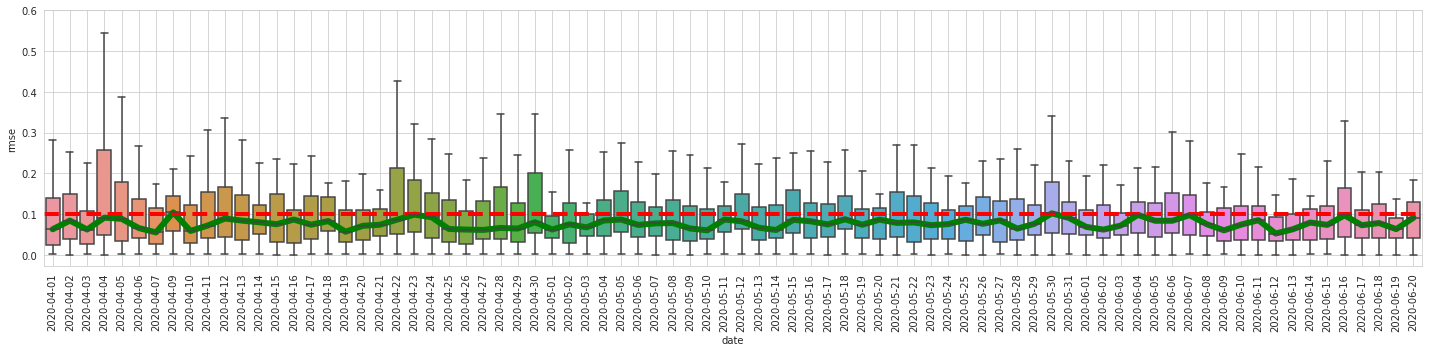

In [217]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='rmse',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='rmse',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,0.7,0.1))

ax.axhline(0.1, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("RMSE evolution (incoming flow)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'rmse_incoming_prov.png'))

In [218]:
median_date_results_df= date_results_df.groupby('date')['overlap'].median().to_frame()

### Origin overlap

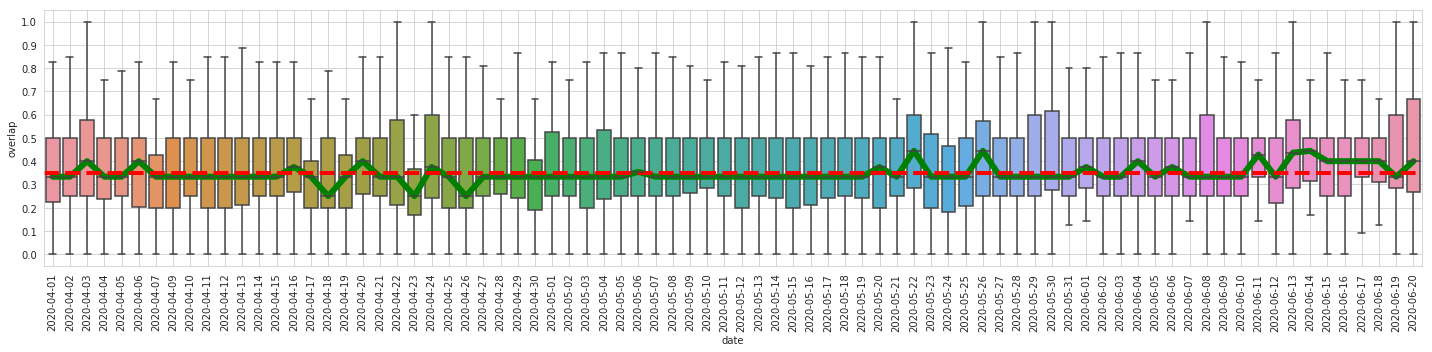

In [325]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=date_results_df, x='date', y='overlap',showfliers = False);

ax = sns.lineplot(data=median_date_results_df.reset_index(), x='date', y='overlap',ax=ax, linewidth=6, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0,1.1,0.1))

ax.axhline(0.35, linewidth=4, color='red', linestyle='--')

ax.grid(True)
#plt.title("Origin overlap evolution");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'origin_overlap_prov.png'))

## Compare number of active MAs

In [220]:
def calculate_num_orig_dest_fn():
    results = []
    for d in tqdm_notebook(target_days):
        twt_n_origins = twt_ods[d][twt_ods[d]['total']>0].shape[0]-1
        twt_n_destinations = twt_ods[d].loc['total'][twt_ods[d].loc['total']>0].shape[0]-1
        
        results.append((twt_n_origins, 'origin', 'TWT',d))
        results.append((twt_n_destinations, 'destination', 'TWT',d))

        
        ine_n_origins = ine_ods[d][ine_ods[d]['total']>0].shape[0]-1
        ine_n_destinations =ine_ods[d].loc['total'][ine_ods[d].loc['total']>0].shape[0]-1
        
        results.append((ine_n_origins, 'origin', 'INE',d))
        results.append((ine_n_destinations, 'destination', 'INE',d))
        
    result_df= pd.DataFrame(results, columns='number type source date'.split())
    result_df['date'] = result_df['date'].astype(str)

    return result_df

In [221]:
n_origin_dest_df = calculate_num_orig_dest_fn()

In [222]:
n_origin_dest_df.head()

,number,type,source,date
0,43,origin,TWT,2020-04-01
1,45,destination,TWT,2020-04-01
2,52,origin,INE,2020-04-01
3,52,destination,INE,2020-04-01
4,44,origin,TWT,2020-04-02


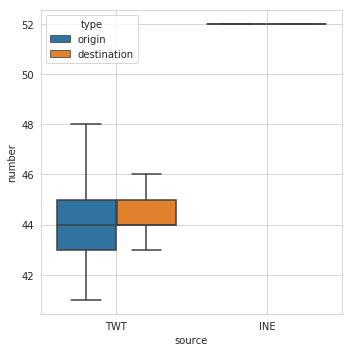

In [223]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=n_origin_dest_df, x='source', y='number',hue='type', showfliers = False);
ax.grid(True)
#plt.title("Number of origin-destinations (no threshold)");
plt.tight_layout()
plt.savefig(os.path.join('figs', 'num_origin_dest_prov.png'))

In [224]:
n_origin_df = n_origin_dest_df[n_origin_dest_df['type']=='origin']
n_dest_df = n_origin_dest_df[n_origin_dest_df['type']=='destination']

In [225]:
n_origin_df.head()

,number,type,source,date
0,43,origin,TWT,2020-04-01
2,52,origin,INE,2020-04-01
4,44,origin,TWT,2020-04-02
6,52,origin,INE,2020-04-02
8,46,origin,TWT,2020-04-03


### Number of MAs acting as trip origin

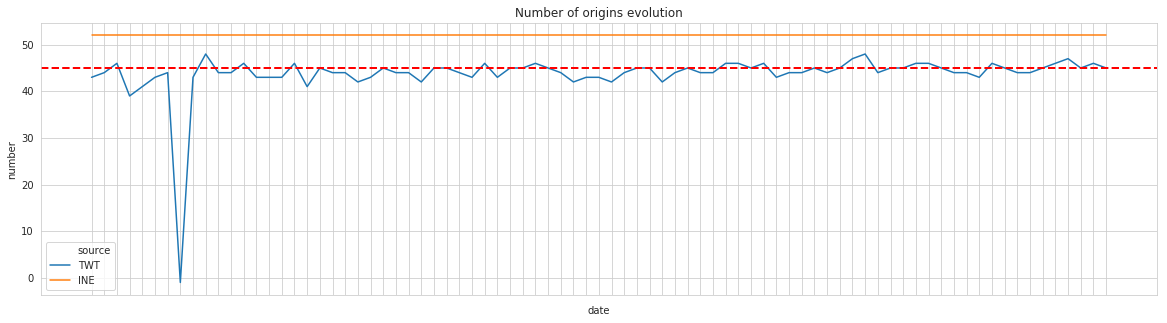

In [226]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")

ax = sns.lineplot(data=n_origin_df, x='date', y='number',hue='source')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.axhline(45, linewidth=2, color='red', linestyle='--')
#ax.axhline(2900, linewidth=2, color='red', linestyle='--')


ax.grid(True)
plt.title("Number of origins evolution");

#### Correlation

In [227]:
import scipy.stats as stats

In [228]:
r, p = stats.pearsonr(n_origin_df[n_origin_df['source']=='TWT']['number'], 
                      n_origin_df[n_origin_df['source']=='INE']['number'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: nan and p-value: 1.0


## Number of MAs acting as trip destinations

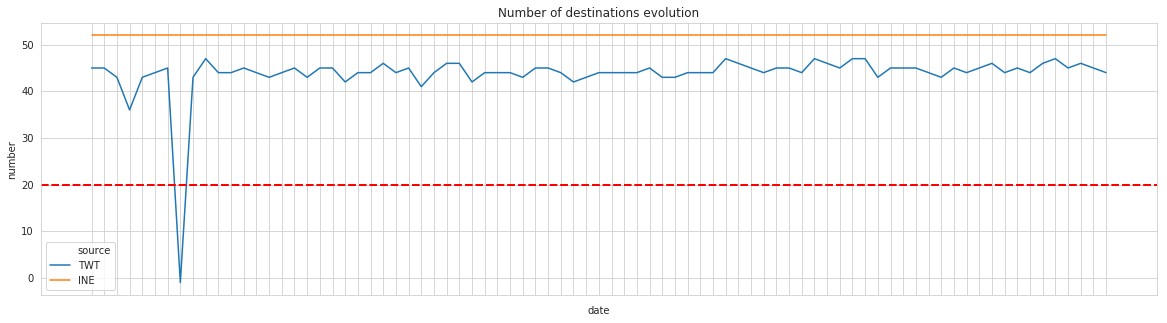

In [229]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")

ax = sns.lineplot(data=n_dest_df, x='date', y='number',hue='source')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.axhline(20, linewidth=2, color='red', linestyle='--')
ax.axhline(20, linewidth=2, color='red', linestyle='--')


ax.grid(True)
plt.title("Number of destinations evolution");

In [230]:
import scipy.stats as stats

#### Correlation

In [231]:
r, p = stats.pearsonr(n_dest_df[n_dest_df['source']=='TWT']['number'], 
                      n_dest_df[n_dest_df['source']=='INE']['number'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: nan and p-value: 1.0


## Evolution of the trips distances

In [232]:
province_gdf = gpd.read_file(os.path.join('data', 'provinces_with_code.geojson'), encoding='utf-8').to_crs({'init': 'epsg:25830'})
province_gdf['CODEUNIT'] = province_gdf['CODEUNIT'].astype(int)
province_gdf.head()

,NATCODE,NAMEUNIT,CODEUNIT,geometry
0,34104600000,València/Valencia,46,"MULTIPOLYGON (((653037.661 4429500.236, 652229..."
1,34084500000,Toledo,45,"POLYGON ((294238.465 4416957.428, 294235.467 4..."
2,34024400000,Teruel,44,"POLYGON ((765333.011 4512252.351, 764732.031 4..."
3,34094300000,Tarragona,43,"MULTIPOLYGON (((813560.435 4504876.753, 813537..."
4,34074200000,Soria,42,"POLYGON ((583890.589 4603311.305, 583939.589 4..."


In [233]:
prov_codes= province_gdf['CODEUNIT'].unique().tolist()

In [234]:
prov_distances_df = pd.DataFrame(0,columns=prov_codes, index=prov_codes)

In [235]:
from itertools import combinations

In [236]:
for o_prov, d_prov in combinations(prov_codes, r=2):
    po_centroid = province_gdf[province_gdf['CODEUNIT']==o_prov]['geometry'].iloc[0].centroid
    pd_centroid = province_gdf[province_gdf['CODEUNIT']==d_prov]['geometry'].iloc[0].centroid
    prov_distances_df.loc[o_prov,d_prov]= po_centroid.distance(pd_centroid)/1000
    prov_distances_df.loc[d_prov,o_prov]= po_centroid.distance(pd_centroid)/1000

In [237]:
prov_distances_df.head()

,46,45,44,43,42,41,40,39,37,36,...,3,2,1,-1,52,51,50,49,48,47
46,0.000000,291.368806,143.424029,235.275035,292.355203,477.344432,341.488288,503.798380,476.454614,729.672545,...,100.898049,118.694836,417.207349,559.437942,490.950246,556.180286,250.871945,510.686225,462.636302,425.150144
45,291.368806,0.000000,299.192009,444.805678,241.670532,294.067345,152.964485,377.991586,197.996684,466.343327,...,341.962578,215.553252,358.029028,445.000676,510.714048,445.545774,329.931798,264.480838,397.275429,212.540100
44,143.424029,299.192009,0.000000,145.666167,182.967735,552.581190,278.513249,387.685046,443.567313,667.479778,...,243.265583,226.876222,288.641268,662.740829,624.580339,660.566806,108.457713,448.759121,332.185007,354.972638
43,235.275035,444.805678,145.666167,0.000000,291.060130,691.757004,409.098550,464.036671,580.213566,785.759535,...,313.230066,346.757615,351.564891,790.480488,722.918368,787.647869,168.130881,572.439384,385.906541,477.592194
42,292.355203,241.670532,182.967735,291.060130,0.000000,535.233240,132.354162,211.503362,305.287156,494.798350,...,389.033447,314.588278,135.264216,679.308956,703.042258,679.060145,127.066348,282.478331,180.904116,188.077306


In [238]:
prov_distances_df.columns= prov_distances_df.columns.astype(str)
prov_distances_df.index= prov_distances_df.index.astype(str)

In [239]:
from statistics import median

def calculate_avg_distance_trips_fn(od):
    od_no_total =od.drop('total',axis=0)
    od_no_totals = od_no_total.drop('total', axis=1)
    results_df = od_no_totals.mul(prov_distances_df)
    total_sum_by_ma = results_df.sum(axis=1)
    avg_by_ma= (total_sum_by_ma /od['total']).fillna(0)
    nozero_avg= avg_by_ma[avg_by_ma>0]
    if len(nozero_avg)>0:
        #avg_dist = median(nozero_avg)#
        avg_dist = sum(nozero_avg)/len(nozero_avg)
        return avg_dist
    else:
        return 0

In [240]:
twt_avg_dist= []
for date, od in tqdm_notebook(twt_ods.items()): 
    dist_= calculate_avg_distance_trips_fn(od)
    twt_avg_dist.append((date, dist_))

In [241]:
twt_avg_dist_df = pd.DataFrame.from_records(twt_avg_dist,columns='date avg_dist'.split())
twt_avg_dist_df = twt_avg_dist_df.set_index('date')

In [242]:
ine_avg_dist= []
for date, od in tqdm_notebook(ine_ods.items()): 
    dist_= calculate_avg_distance_trips_fn(od)
    ine_avg_dist.append((date, dist_))

In [243]:
ine_avg_dist_df = pd.DataFrame.from_records(ine_avg_dist,columns='date avg_dist'.split())
ine_avg_dist_df = ine_avg_dist_df.set_index('date')

In [244]:
twt_avg_dist_df['ine_avg_dist']= ine_avg_dist_df['avg_dist']

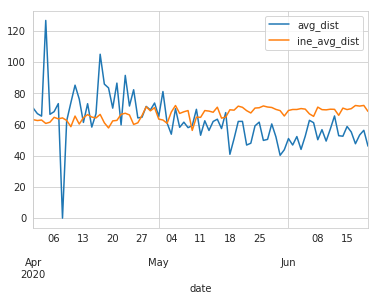

In [245]:
twt_avg_dist_df.plot(grid=True);

In [246]:
import scipy.stats as stats

In [247]:
r, p = stats.pearsonr(twt_avg_dist_df['avg_dist'], 
                      twt_avg_dist_df['ine_avg_dist'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.4110045655199441 and p-value: 0.0001381677874133751


In [248]:
from statsmodels.tsa.seasonal import seasonal_decompose

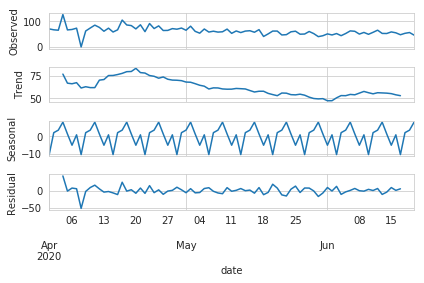

In [249]:
result = seasonal_decompose(twt_avg_dist_df['avg_dist'], model='additive', freq=7);
result.plot();

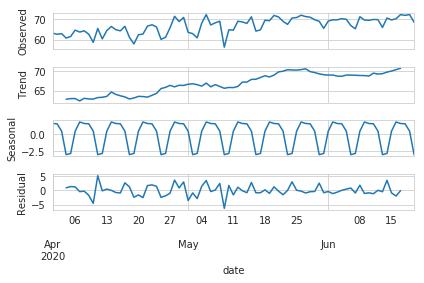

In [250]:
result = seasonal_decompose(twt_avg_dist_df['ine_avg_dist'], model='additive', freq=7);
result.plot();

# Evolution total num trips vs COVID cases

In [251]:
covid_cases_df = pd.read_csv(os.path.join(data_path,'Spain-INE-covid-mob-study-mar-jun-20','COVID datos_provincias.csv'), sep=';')

In [252]:
target_covid_cases_df = covid_cases_df[covid_cases_df['mes'].isin([4, 5, 6])]

In [253]:
target_covid_cases_df.head()

,Provincia_cod,dia,mes,num_casos
61,1,1,4,52
62,1,2,4,46
63,1,3,4,70
64,1,4,4,25
65,1,5,4,33


In [254]:
def calculate_accumulative_cases_fn(covid_df):
    result_covid_df = covid_df.copy()
    result_covid_df['cumulative_cases']=0
    for prov in tqdm_notebook(covid_df['Provincia_cod'].unique()):
        total_cases =0
        prov_covid_df = covid_df[covid_df['Provincia_cod']==prov]
        for month in [4, 5, 6]:
            #print('mes', month)
            days_list = prov_covid_df[prov_covid_df['mes']==month]['dia'].unique().tolist()
            days_list.sort()
            for day in days_list:
                #print(day)
                day_row = prov_covid_df[(prov_covid_df['mes']==month)& (prov_covid_df['dia']==day)]
                total_cases += day_row['num_casos'].values[0]
                #day_row['cumulative_cases'] = total_cases 
                #print(day_row.index[0], total_cases)
                result_covid_df.loc[day_row.index[0],'cumulative_cases']= total_cases
                #print(month, day, day_row,)
                
    return result_covid_df

In [255]:
accumulative_covid_df = calculate_accumulative_cases_fn(target_covid_cases_df)

In [256]:
accumulative_covid_df.head()

,Provincia_cod,dia,mes,num_casos,cumulative_cases
61,1,1,4,52,52
62,1,2,4,46,98
63,1,3,4,70,168
64,1,4,4,25,193
65,1,5,4,33,226


In [257]:
import datetime

In [258]:
def generate_num_cases_trips_fn():
    num_cases_trips = []
    for date_ in twt_ods:
        twt_od = twt_ods[date_]
        n_twt_trips = twt_od.loc['total','total']
        ine_od = ine_ods[date_]
        n_ine_trips = ine_ods[date_].loc['total','total']
        month = date_.month
        day = date_.day
        n_covid_cases = covid_cases_df[(covid_cases_df['dia']==day) & (covid_cases_df['mes']==month)]['num_casos'].sum()
        num_cases_trips.append((date_,n_twt_trips, n_ine_trips, n_covid_cases))
    
    df=  pd.DataFrame.from_records(num_cases_trips,columns='date n_twt_trips n_ine_trips COVID_cases'.split())
    return df.set_index('date')

In [259]:
trips_cases_df = generate_num_cases_trips_fn()

In [260]:
trips_cases_df.head()

,n_twt_trips,n_ine_trips,COVID_cases
date,,,
2020-04-01,2375,22241,5687
2020-04-02,2450,21533,4608
2020-04-03,2503,22823,4605
2020-04-04,554,20291,3943
2020-04-05,1319,20900,3501


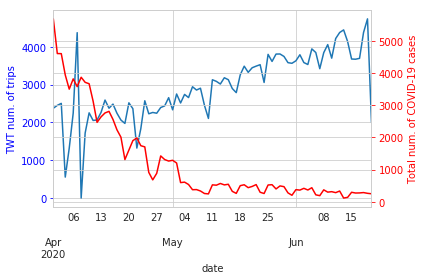

In [261]:
ax= trips_cases_df['n_twt_trips'].plot();
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
trips_cases_df['COVID_cases'].plot(ax=ax2, color='red');

ax.set_ylabel('TWT num. of trips')
ax2.set_ylabel('Total num. of COVID-19 cases')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_n_trips_vs_covid_prov.png'))

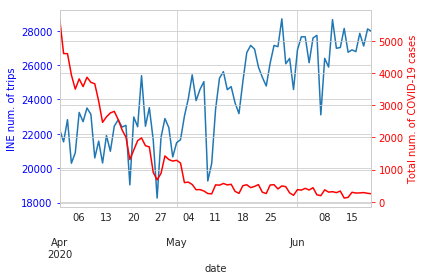

In [262]:
ax= trips_cases_df['n_ine_trips'].plot();
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
trips_cases_df['COVID_cases'].plot(ax=ax2, color='red');

ax.set_ylabel('INE num. of trips')
ax2.set_ylabel('Total num. of COVID-19 cases')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_n_trips_vs_covid_prov.png'))

In [263]:
from statsmodels.tsa.seasonal import seasonal_decompose

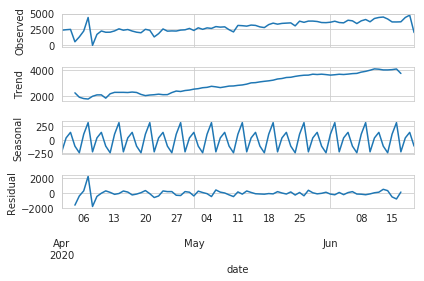

In [264]:
result = seasonal_decompose(trips_cases_df['n_twt_trips'], model='additive', freq=7);
result.plot();
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_n_trips_evol_prov.png'))

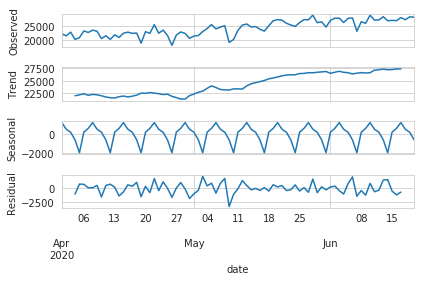

In [265]:
result = seasonal_decompose(trips_cases_df['n_ine_trips'], model='additive', freq=7);
result.plot();
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_n_trips_evol_prov.png'))

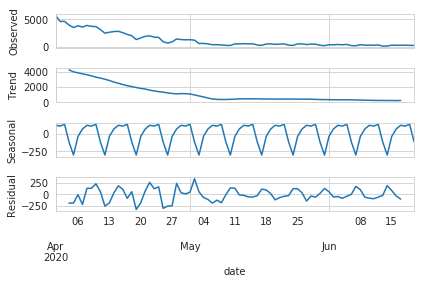

In [266]:
result = seasonal_decompose(trips_cases_df['COVID_cases'], model='additive', freq=7);
result.plot();

Correlation ine and twt trips

In [267]:
r, p = stats.pearsonr(trips_cases_df['n_twt_trips'], 
                      trips_cases_df['n_ine_trips'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.7158367454490321 and p-value: 5.884477843731312e-14


In [268]:
r, p = stats.pearsonr(trips_cases_df['n_twt_trips'], 
                      trips_cases_df['COVID_cases'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.6131054759132653 and p-value: 1.1703258440867765e-09


In [269]:
r, p = stats.pearsonr(trips_cases_df['n_ine_trips'], 
                      trips_cases_df['COVID_cases'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.5541132037237725 and p-value: 8.030042311629875e-08


## Time Lagged Cross Correlation

In [270]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

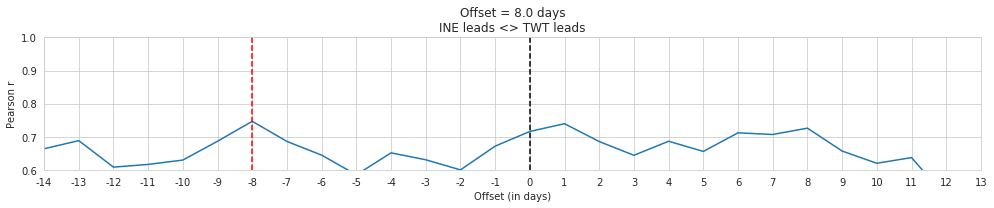

In [271]:
d1 = trips_cases_df['n_ine_trips']
d2 = trips_cases_df['n_twt_trips']
rs = [crosscorr(d1,d2, lag) for lag in range(-14,14)]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} days\nINE leads <> TWT leads',ylim=[0.6,1],xlim=[0,24], xlabel='Offset (in days)',ylabel='Pearson r')
ax.set_xticks(np.arange(0,28))
ax.set_xticklabels(np.arange(-14,14));
ax.grid(True)
#ax.set_grid(True)
#plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('figs', 'time_lagged_correlation_prov.png'))

# Evolution of trips based on COVID cases in origin and destination

In [272]:
import math
def get_n_trips_per_covid_diff_fn(target_days, twt_ods_sample, ine_ods_sample, cases_type='daily'):
    
    twt_result = dict.fromkeys([round(x,1) for x in np.arange(-1,1.1,0.1)],0)
    ine_result = dict.fromkeys([round(x,1) for x in np.arange(-1,1.1,0.1)],0)
    
    covid_col_name= 'num_casos'
    if cases_type == 'aggregated':
        covid_col_name = 'cumulative_cases'
    
    for d in tqdm_notebook(target_days):
        #print(d)
        twt_od = twt_ods_sample[d]
        ine_od = ine_ods_sample[d]
        day = d.day
        month = d.month
        date_covid = accumulative_covid_df[(accumulative_covid_df['dia']==day) & 
                                           (accumulative_covid_df['mes']==month)]
        #print(date_covid)
        for o_prov, d_prov in combinations(prov_codes, r=2):

            num_cases_o_val = date_covid[date_covid['Provincia_cod']==o_prov][covid_col_name].values
            num_cases_d_val = date_covid[date_covid['Provincia_cod']==d_prov][covid_col_name].values
            #print(num_cases_o_val, num_cases_d_val)
            if len(num_cases_o_val)>0 and len(num_cases_d_val)>0:
                num_cases_o= num_cases_o_val[0]
                num_cases_d= num_cases_d_val[0]

                diff_cases_o_d = (num_cases_d-num_cases_o)/(num_cases_d + num_cases_o)
                if not math.isnan(diff_cases_o_d):
                    #print(diff_cases_o_d)
                    diff_cases_o_d = round(diff_cases_o_d,1)
                    #print(diff_cases_o_d, twt_od.loc[str(o_prov), str(d_prov)], twt_result[diff_cases_o_d])
                    twt_result[diff_cases_o_d] += twt_od.loc[str(o_prov), str(d_prov)] 
                    ine_result[diff_cases_o_d] += ine_od.loc[str(o_prov), str(d_prov)] 

                    diff_cases_d_o = (num_cases_o-num_cases_d)/(num_cases_d + num_cases_o)
                    #print(round(diff_cases_d_o,1))
                    diff_cases_d_o = round(diff_cases_d_o,1)
                    twt_result[diff_cases_d_o] += twt_od.loc[str(d_prov), str(o_prov)]
                    ine_result[diff_cases_d_o] += ine_od.loc[str(d_prov), str(o_prov)] 

            
    twt_total = sum(twt_result.values(), 0.0)
    norm_twt_result = {k: (v / twt_total)*100 for k, v in twt_result.items()}
    
    ine_total = sum(ine_result.values(), 0.0)
    norm_ine_result = {k: (v / ine_total)*100 for k, v in ine_result.items()}

    data = []
    for k,twt_value in norm_twt_result.items():
        data.append((str(k), twt_value, norm_ine_result[k]))
    
    return pd.DataFrame.from_records(data, columns='covid_rate_diff perc_twt perc_ine'.split())

In [273]:
def plot_trips_covid_dist_fn(df_):
    fig, axes = plt.subplots(ncols=2, sharey=True)
    axes[0].barh(df_trips['covid_rate_diff'], df_trips['perc_twt'], align='center', color='gray')
    axes[0].set(title='TWT')
    axes[1].barh(df_trips['covid_rate_diff'], df_trips['perc_ine'], align='center', color='gray')
    axes[1].set(title='INE')
    axes[0].invert_xaxis()
    
    max_t = max(df_trips['perc_twt'].max(), df_trips['perc_ine'].max())

    axes[0].set_yticklabels('-100% -90% -80% -70% -60% -50% -40% -30% -20% -10% 0% +10% +20% +30% +40% +50% +60% +70% +80% +90% +100%'.split())
    axes[0].set_xticks(np.arange(0,max_t+1,1))
    axes[0].yaxis.tick_right()
    axes[1].set_xticks(np.arange(0,max_t+1,1))

    if max_t > 15:
        plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=90 )
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=90 )
   
    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.25)
    
    plt.show() 

In [274]:
e_date = datetime.datetime.strptime('2020-04-19', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
target_days_p1 = generate_target_days_fn(i_date, e_date)

e_date = datetime.datetime.strptime('2020-05-03', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-20', '%Y-%m-%d')
target_days_p2 = generate_target_days_fn(i_date, e_date)

e_date = datetime.datetime.strptime('2020-05-17', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-04', '%Y-%m-%d')
target_days_p3 = generate_target_days_fn(i_date, e_date)

e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-18', '%Y-%m-%d')
target_days_p4 = generate_target_days_fn(i_date, e_date)

e_date = datetime.datetime.strptime('2020-06-14', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-01', '%Y-%m-%d')
target_days_p5 = generate_target_days_fn(i_date, e_date)

e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-15', '%Y-%m-%d')
target_days_p6 = generate_target_days_fn(i_date, e_date)

### Daily COVID cases

In [275]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p1, twt_ods, ine_ods)

In [276]:
df_trips.head()

,covid_rate_diff,perc_twt,perc_ine
0,-1.0,2.939142,1.172800
1,-0.9,11.082296,5.613337
2,-0.8,7.780083,5.682965
3,-0.7,4.840941,5.644670
4,-0.6,3.751729,5.050219


https://stackoverflow.com/questions/27694221/using-python-libraries-to-plot-two-horizontal-bar-charts-sharing-same-y-axis

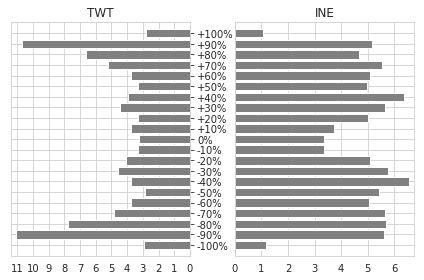

In [277]:
plot_trips_covid_dist_fn(df_trips)

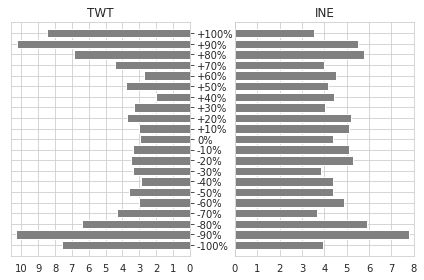

In [278]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p2, twt_ods, ine_ods)
plot_trips_covid_dist_fn(df_trips)

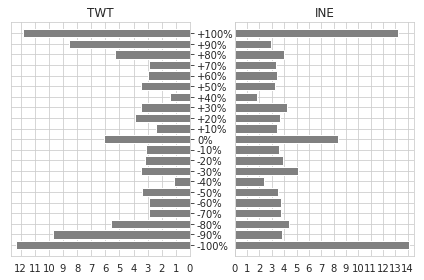

In [279]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p3, twt_ods, ine_ods)
plot_trips_covid_dist_fn(df_trips)

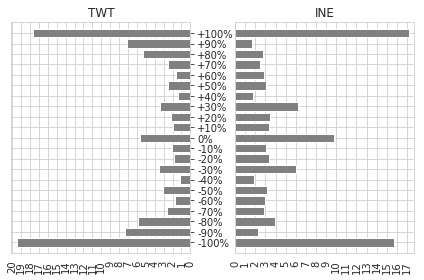

In [280]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p4, twt_ods, ine_ods)
plot_trips_covid_dist_fn(df_trips)

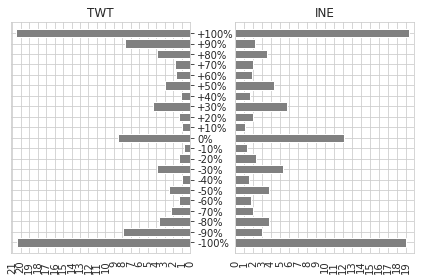

In [281]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p5, twt_ods, ine_ods)
plot_trips_covid_dist_fn(df_trips)

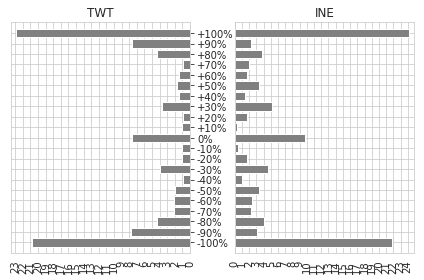

In [282]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p6, twt_ods, ine_ods)
plot_trips_covid_dist_fn(df_trips)

### Accumulated COVID cases

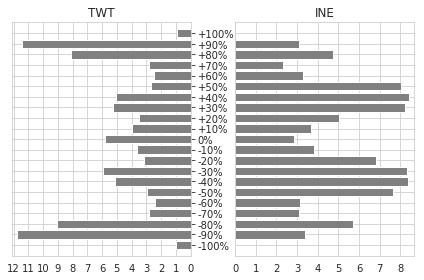

In [283]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p1, twt_ods, ine_ods, cases_type='aggregated')
plot_trips_covid_dist_fn(df_trips)

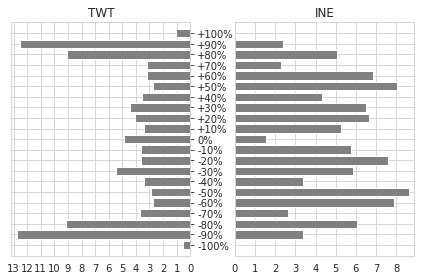

In [284]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p2, twt_ods, ine_ods, cases_type='aggregated')
plot_trips_covid_dist_fn(df_trips)

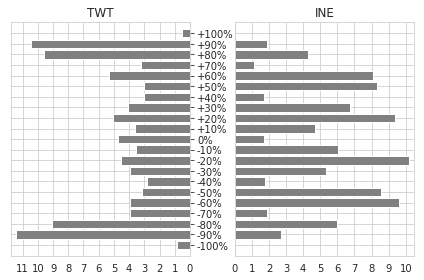

In [285]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p3, twt_ods, ine_ods, cases_type='aggregated')
plot_trips_covid_dist_fn(df_trips)

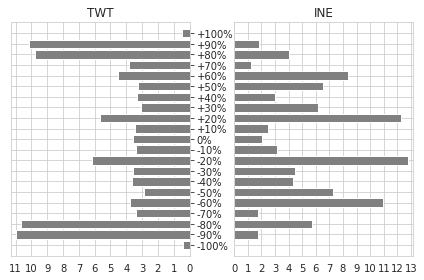

In [286]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p4, twt_ods, ine_ods, cases_type='aggregated')
plot_trips_covid_dist_fn(df_trips)

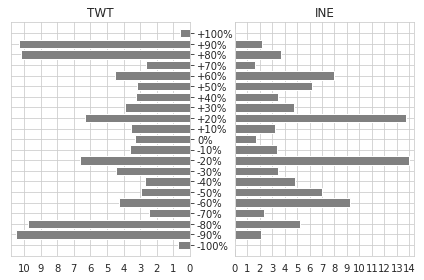

In [287]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p5, twt_ods, ine_ods, cases_type='aggregated')
plot_trips_covid_dist_fn(df_trips)

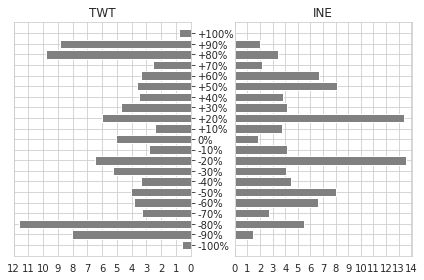

In [288]:
df_trips= get_n_trips_per_covid_diff_fn(target_days_p6, twt_ods, ine_ods, cases_type='aggregated')
plot_trips_covid_dist_fn(df_trips)

# Variation of mobility vs COVID

In [289]:
from datetime import date, timedelta

def generate_week_days_fn(init_date):

    target_days = []
    for i in range(7):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [290]:
weeks= []

#first week
e_date = datetime.datetime.strptime('2020-04-05', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
target_days_w1 = generate_target_days_fn(i_date, e_date)
weeks.append(target_days_w1)

for w in range(0,10):
    week_days = generate_week_days_fn(e_date + timedelta(days=1))
    weeks.append(week_days)
    e_date = week_days[-1]

#last week    
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-15', '%Y-%m-%d')
target_days_wf = generate_target_days_fn(i_date, e_date)
weeks.append(target_days_wf)

In [291]:
date_ = datetime.datetime.strptime('2020-04-12', '%Y-%m-%d')

twt_od = twt_ods[date_]

In [292]:
date_ = datetime.datetime.strptime('2020-04-12', '%Y-%m-%d')

twt_od = twt_ods[date_]

In [293]:
def get_trips_variation_fn(ods):
    previous_ntrips = []
    previous_ntrips_input= []
    i=1
    for w in weeks:
        prev_od = None
        for day in w:
            twt_od= ods[day]
            if prev_od is not None:
                prev_od = prev_od.add(twt_od, axis=1)
            else:
                prev_od = twt_od
        previous_ntrips.append(prev_od['total'])
        previous_ntrips_input.append(prev_od.loc['total'].T)
        
        i += 1
    n_trips_diff = []
    for i in range(0,len(previous_ntrips)-1):
        
        #Difference in the number of outgoing trips
        trips_week_prev = previous_ntrips[i]
        trips_week_curr = previous_ntrips[i+1]
        diff = ((trips_week_curr-trips_week_prev)/(trips_week_curr+trips_week_prev))*100
        
        #Difference in the number of incoming trips
        trips_week_prev_input = previous_ntrips_input[i]
        trips_week_curr_input = previous_ntrips_input[i+1]
        diff_input = ((trips_week_curr_input-trips_week_prev_input)/(trips_week_curr_input+trips_week_prev_input))*100

        diff_df = diff.to_frame()
        diff_df['input_trips_diff']= diff_input
        
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={'index':'prov', 'total':'trips_diff'})
        diff_df['week']= i+1
        n_trips_diff.append(diff_df)
    
    df_ = pd.concat(n_trips_diff, axis=0)
    df=df_.dropna(axis=0)
    return df_.reset_index()

In [294]:
twt_ntrips_diff = get_trips_variation_fn(twt_ods)

In [295]:
twt_ntrips_diff.tail()

,index,prov,trips_diff,input_trips_diff,week
578,48,49,4.000000,2.380952,11
579,49,48,100.000000,0.000000,11
580,50,50,-9.239130,-12.711864,11
581,51,7,-11.985689,-12.455090,11
582,52,total,-12.997389,-12.997389,11


In [296]:
ine_ntrips_diff = get_trips_variation_fn(ine_ods)

In [297]:
ine_ntrips_diff.head()

,index,prov,trips_diff,input_trips_diff,week
0,0,3,16.856892,16.950991,1
1,1,8,11.956009,15.738499,1
2,2,28,13.229317,12.972509,1
3,3,41,18.604995,19.938229,1
4,4,46,22.469764,19.134588,1


In [298]:
covid_cases_df.head()

,Provincia_cod,dia,mes,num_casos
0,1,31,1,0
1,1,1,2,0
2,1,2,2,0
3,1,3,2,0
4,1,4,2,0


In [299]:
prev_week_cases = None
covid_cases_diff = []
nweek=1
for w in weeks:
    curr_week_cases = dict.fromkeys([prov for prov in covid_cases_df['Provincia_cod'].unique()],0)

    for date in w:
        day = date.day
        month = date.month
        date_covid = accumulative_covid_df[(covid_cases_df['dia']==day) & 
                                           (covid_cases_df['mes']==month)]
        
        for prov in date_covid['Provincia_cod'].unique():
            curr_week_cases[prov] += date_covid[date_covid['Provincia_cod']==prov]['num_casos'].values[0]
    
    if prev_week_cases is not None:
        diff_dict = {k: ((curr_week_cases.get(k, 0) - prev_week_cases.get(k, 0))/(curr_week_cases.get(k, 0) + prev_week_cases.get(k, 0)))*100 
                     for k in set(curr_week_cases)}
        covid_cases_diff.append(diff_dict)     
    prev_week_cases = curr_week_cases

In [300]:
twt_ntrips_diff.tail()

,index,prov,trips_diff,input_trips_diff,week
578,48,49,4.000000,2.380952,11
579,49,48,100.000000,0.000000,11
580,50,50,-9.239130,-12.711864,11
581,51,7,-11.985689,-12.455090,11
582,52,total,-12.997389,-12.997389,11


In [301]:
def add_covid_diff_cases_fn(n_trips_diff_df, covid_cases_diff):
    n_trips_diff_df['covid_diff']=0
    week_num = 1
    for diff in covid_cases_diff:
        for prov, cases_var in diff.items():
            target_df = n_trips_diff_df[(n_trips_diff_df['prov']==str(prov)) & (n_trips_diff_df['week']==week_num)]
            index = target_df.index.tolist()[0]
            n_trips_diff_df.loc[index, 'covid_diff']= cases_var
            
        week_num += 1
    return n_trips_diff_df

In [302]:
twt_diff_df= add_covid_diff_cases_fn(twt_ntrips_diff, covid_cases_diff)

In [303]:
twt_diff_df.head()

,index,prov,trips_diff,input_trips_diff,week,covid_diff
0,0,3,15.127175,13.947368,1,-9.205021
1,1,8,25.613383,25.271434,1,8.137845
2,2,28,23.195677,23.506744,1,-1.685639
3,3,41,35.305466,35.185185,1,-8.641975
4,4,46,22.059954,22.239264,1,10.877193


### TWT outgoing trips

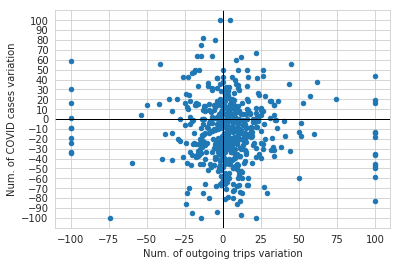

In [304]:
ax= twt_diff_df.plot(kind='scatter', x='trips_diff', y='covid_diff')
ax.set_yticks(np.arange(-100,110,10));
ax.set_xlabel("Num. of outgoing trips variation")
ax.set_ylabel("Num. of COVID cases variation")
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

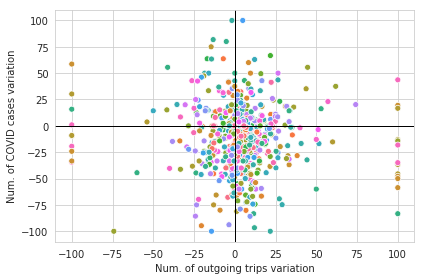

In [305]:
ax =sns.scatterplot(x="trips_diff", y="covid_diff", hue="prov", data=twt_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of outgoing trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_covid_vs_outgoing_trips.png'))

### TWT incoming trips

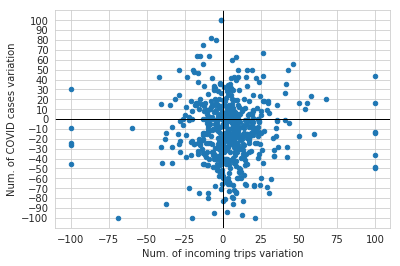

In [306]:
ax= twt_diff_df.plot(kind='scatter', x='input_trips_diff', y='covid_diff')
ax.set_yticks(np.arange(-100,110,10));
ax.set_xlabel("Num. of incoming trips variation")
ax.set_ylabel("Num. of COVID cases variation")
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

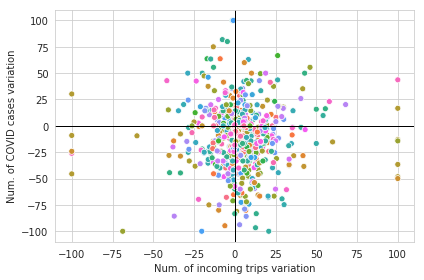

In [307]:
ax =sns.scatterplot(x="input_trips_diff", y="covid_diff", hue="prov", data=twt_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of incoming trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'twt_covid_vs_incoming_trips.png'))

### Correlation study

#### TWT

In [308]:
df_ = twt_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.00816812866832864 and p-value: 0.8502148894439048


In [309]:
df_ = twt_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['input_trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.014663809358245891 and p-value: 0.7345836148479867


#### INE

In [310]:
ine_diff_df= add_covid_diff_cases_fn(ine_ntrips_diff, covid_cases_diff)

In [311]:
df_ = ine_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.026754088795650388 and p-value: 0.5201923804870969


In [312]:
df_ = ine_diff_df.dropna(axis=0)

r, p = stats.pearsonr(df_['input_trips_diff'], 
                      df_['covid_diff'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.021785741604486784 and p-value: 0.6005565007541154


### INE outgoing trips

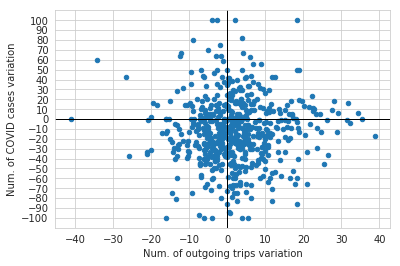

In [313]:
ax= ine_diff_df.plot(kind='scatter', x='trips_diff', y='covid_diff')
ax.set_yticks(np.arange(-100,110,10));
ax.set_xlabel("Num. of outgoing trips variation")
ax.set_ylabel("Num. of COVID cases variation")
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

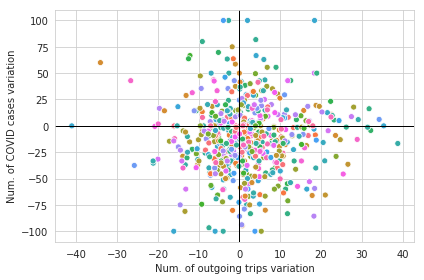

In [314]:
ax =sns.scatterplot(x="trips_diff", y="covid_diff", hue="prov", data=ine_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of outgoing trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_covid_vs_outgoing_trips.png'))

### INE incoming trips

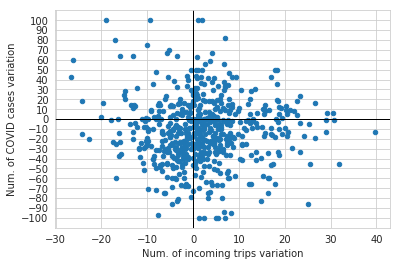

In [315]:
ax= ine_diff_df.plot(kind='scatter', x='input_trips_diff', y='covid_diff')
ax.set_yticks(np.arange(-100,110,10));
ax.set_xlabel("Num. of incoming trips variation")
ax.set_ylabel("Num. of COVID cases variation")
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

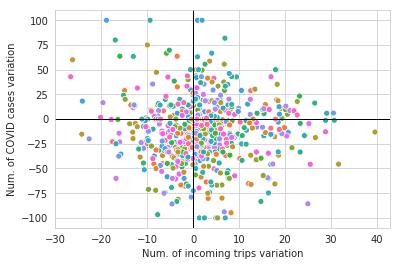

In [316]:
ax =sns.scatterplot(x="input_trips_diff", y="covid_diff", hue="prov", data=ine_diff_df);
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_xlabel("Num. of incoming trips variation")
ax.set_ylabel("Num. of COVID cases variation")
plt.legend([],[], frameon=False);
plt.savefig(os.path.join('figs', 'ine_covid_vs_incoming_trips.png'))

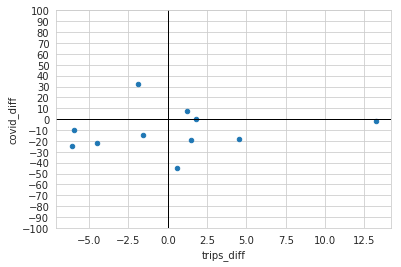

In [317]:
ax= ine_diff_df[ine_diff_df['prov']=='28'].plot(kind='scatter', x='trips_diff', y='covid_diff')
ax.set_yticks(np.arange(-100,110,10));
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

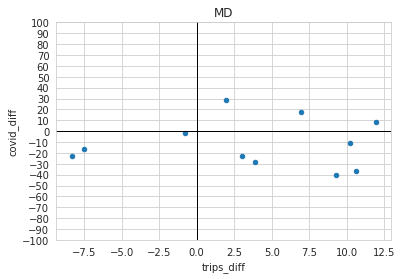

In [318]:
ax= ine_diff_df[ine_diff_df['prov']=='8'].plot(kind='scatter', x='trips_diff', y='covid_diff', title="MD")
ax.set_yticks(np.arange(-100,110,10));
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

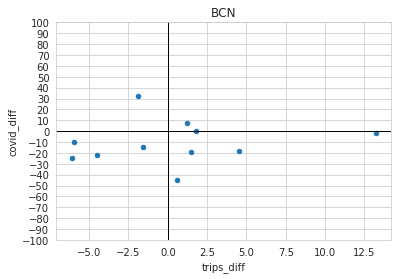

In [319]:
ax= ine_diff_df[ine_diff_df['prov']=='28'].plot(kind='scatter', x='trips_diff', y='covid_diff', title="BCN")
ax.set_yticks(np.arange(-100,110,10));
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");

In [320]:
md_bcn_df = ine_diff_df[ine_diff_df['prov'].isin(['28','8'])]

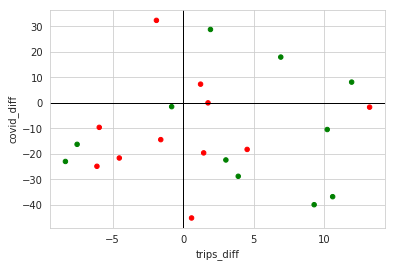

In [321]:
colors = {'28':'red', '8':'green',}

ax= md_bcn_df.plot(kind='scatter', x='trips_diff', y='covid_diff', c=md_bcn_df['prov'].apply(lambda x: colors[x]))
#ax.set_xticks(np.arange(-50,60,10));
#ax.set_yticks(np.arange(-50,60,10));

ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
plt.show()

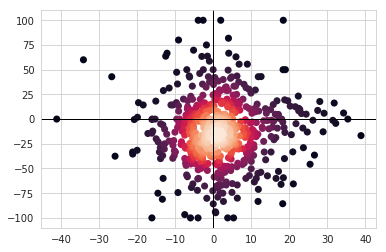

In [322]:
from scipy.stats import gaussian_kde

df_ = ine_diff_df.dropna(axis=0)
# Calculate the point density
x= df_['trips_diff'].values
y= df_['covid_diff'].values
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
plt.show()

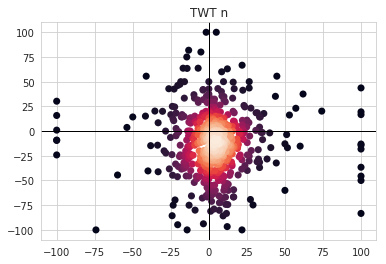

In [323]:
df_ = twt_diff_df.dropna(axis=0)
x= df_['trips_diff'].values
y= df_['covid_diff'].values
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
ax.axhline(linewidth=1, color="k");
ax.axvline(linewidth=1, color="k");
ax.set_title("TWT n")
plt.show()

In [324]:
print("That's all folks")

That's all folks
